# Group Questions

### Index

1. Introduction
2. Q1: What factors influence a country's life expectancy?
3. Q2: What factor set countries apart?

### Introduction

In this notebook, we will try to answer the following questions:

1. **What factors influence a country's life expectancy?**
2. **What factor set countries apart?**

First, we will import the necessary libraries.

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from kneed import KneeLocator

# Types
from polars.dataframe.frame import DataFrame

Now, we will load the cleaned dataset generated in the `01_introduction_and_processing.ipynb` notebook and show its first few rows.

In [2]:
cleaned_data: DataFrame = pl.read_csv(
    source="../data/cleaned/data.csv",
)
cleaned_data.head()

shape: (5, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Density(P ┆ Abbreviat ┆ Agricultu ┆ … ┆ Daily     ┆ Daily     ┆ Daily     ┆ Daily    │
│ ---       ┆ /Km2)     ┆ ion       ┆ ral       ┆   ┆ calorie   ┆ calorie   ┆ calorie   ┆ total    │
│ str       ┆ ---       ┆ ---       ┆ Land(%)   ┆   ┆ supply    ┆ supply    ┆ supply    ┆ caloric  │
│           ┆ f64       ┆ str       ┆ ---       ┆   ┆ per       ┆ per       ┆ per       ┆ ingestio │
│           ┆           ┆           ┆ f64       ┆   ┆ perso…    ┆ perso…    ┆ perso…    ┆ n        │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Afghanist ┆ 60.0      ┆ AF        ┆ 58.1      ┆ … ┆ 39.0      ┆ 16.0      ┆ 1512.0    ┆ 2188.0   │
│ an        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Albania   ┆ 105.0     ┆ AL        ┆ 43.1      ┆ … ┆ 87.0      ┆ 47.0      ┆ 985.0     ┆ 3330.0   │
│ Algeria   ┆ 18.0      ┆ DZ        ┆ 17.4      ┆ … ┆ 109.00001 ┆ 61.000008 ┆ 1616.0001 ┆ 3470.000 │
│           ┆           ┆           ┆           ┆   ┆ 5         ┆           ┆           ┆ 314      │
│ Andorra   ┆ 164.0     ┆ AD        ┆ 40.0      ┆ … ┆ 113.0     ┆ 13.0      ┆ 816.0     ┆ 3552.0   │
│ Angola    ┆ 26.0      ┆ AO        ┆ 47.5      ┆ … ┆ 809.9999  ┆ 66.999985 ┆ 704.9999  ┆ 2372.999 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 627      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

---

## Q1: What factors influence a country's life expectancy?

In order to give an answer to the question *What factors influence a country's life expectancy?*, we will investigate the key factors that influence life expectancy across different countries. Life expectancy is a crucial indicator of a nation’s overall well-being, reflecting healthcare quality, economic conditions, and other factors.

Understanding the determinants of life expectancy is essential for policymakers, healthcare professionals, and economists to improve public health strategies and resource allocation. 
By analyzing global data, this study will identify the most influential factors and their relationships with life expectancy, offering insights into how countries can improve public health outcomes.

As a starting point, we will perform a correlation analysis to identify the variables that are most strongly associated with life expectancy. Then, we will select some insteresting variables that could impact life expectancy and perform an association rule mining analysis to identify the most frequent patterns of these variables.

### Correlation Analysis

A correlation analysis is a statistical technique that measures the strength and direction of the relationship between two variables. The correlation coefficient ranges from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no correlation. We are going to create a heatmap to visualize the correlation matrix between variables, paying special attention to the correlation with life expectancy.

It is important to emphasize that we will be using the Spearman correlation coefficient. Unlike the Pearson correlation, which assumes a linear relationship, Spearman focuses on the ranks or positions of the data rather than their exact values. This is helpful when the data isn't evenly spread out or when the relationship between the variables is more complicated. It allows us to better understand how life expectancy relates to other factors, even if the data is not perfect or has outliers.

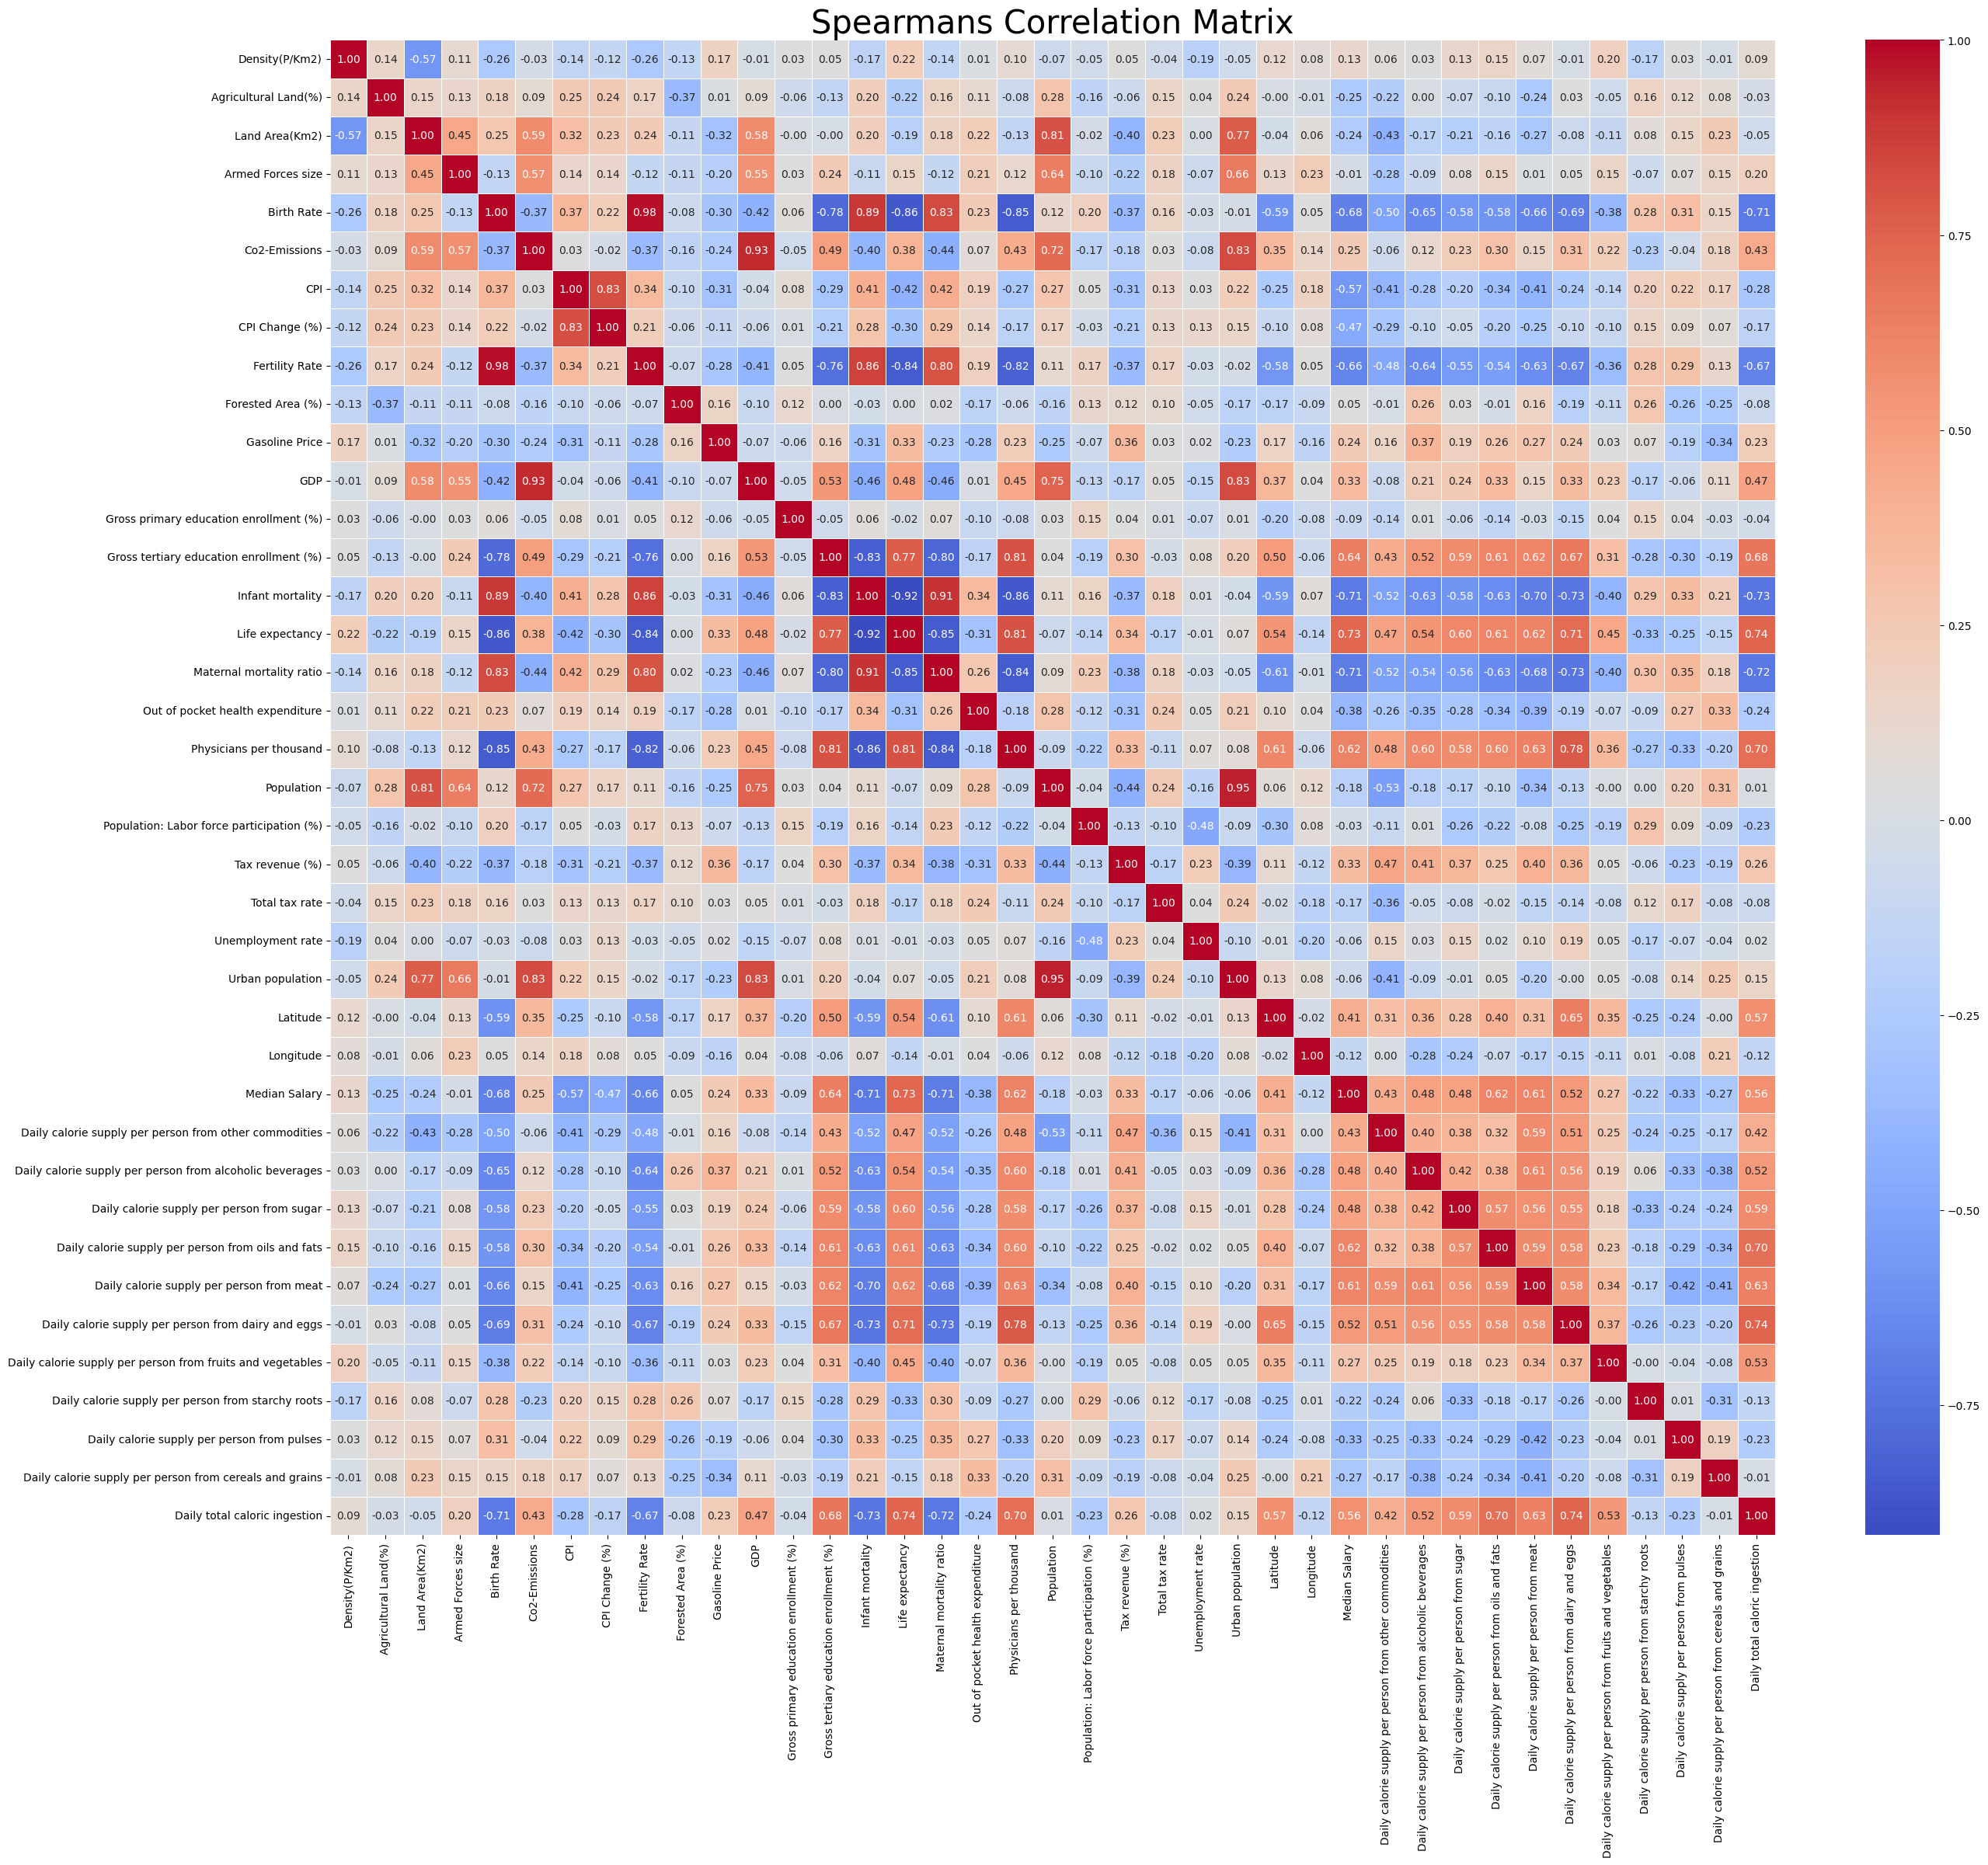

In [3]:
# Delete columns that are not needed for the correlation matrix
corr_data = cleaned_data.drop(["Country", "Abbreviation", "Code", "Year"])

# Convert the Polars DataFrame to a Pandas DataFrame
corr_data = corr_data.to_pandas()

# Calculate the correlation matrix using the Spearman correlation coefficient
correlation_matrix = corr_data.corr(method="spearman")

# Plot the correlation matrix
plt.figure(figsize=(30, 25))
sns.heatmap(
    data=correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title(label="Spearmans Correlation Matrix", fontdict={"fontsize": 30})
plt.show()

Let's see the highest correlations obtained and identify if there are variables that could be eliminated due to multicollinearity.

In [4]:
# Fill the diagonal with NaN to ignore self-correlations
np.fill_diagonal(correlation_matrix.values, np.nan)

# Create a mask for the upper triangle
mask = np.triu(np.ones(correlation_matrix.shape), k=1)

# Apply the mask and unstack the upper triangle
top_correlations = (
    (correlation_matrix * mask).unstack().dropna().sort_values(ascending=False)
)

# Print the sorted correlation pairs
print(top_correlations)

Fertility Rate            Birth Rate          0.981449
Urban population          Population          0.948230
GDP                       Co2-Emissions       0.926008
Maternal mortality ratio  Infant mortality    0.909432
Infant mortality          Birth Rate          0.891335
                                                ...   
Maternal mortality ratio  Life expectancy    -0.845004
Physicians per thousand   Birth Rate         -0.845806
Life expectancy           Birth Rate         -0.859628
Physicians per thousand   Infant mortality   -0.862447
Life expectancy           Infant mortality   -0.916390
Length: 1482, dtype: float64


We find that there are some variables that are highly correlated with each other, so we will remove the following variables from the analysis:
- Fertility Rate: It will be removed due to its high correlation with the Birth Rate, as both variables reflect similar aspects of demographic dynamics.
- Urban population: It will be removed due to its high correlation with Population, as the latter already captures the relevant information about the total population, making the urban variable redundant.
- Maternal mortality ratio: It will be removed due to its high correlation with Infant mortality, as both variables are closely related to maternal and infant health and well-being.

Let's remove these variables and perform the correlation analysis again.

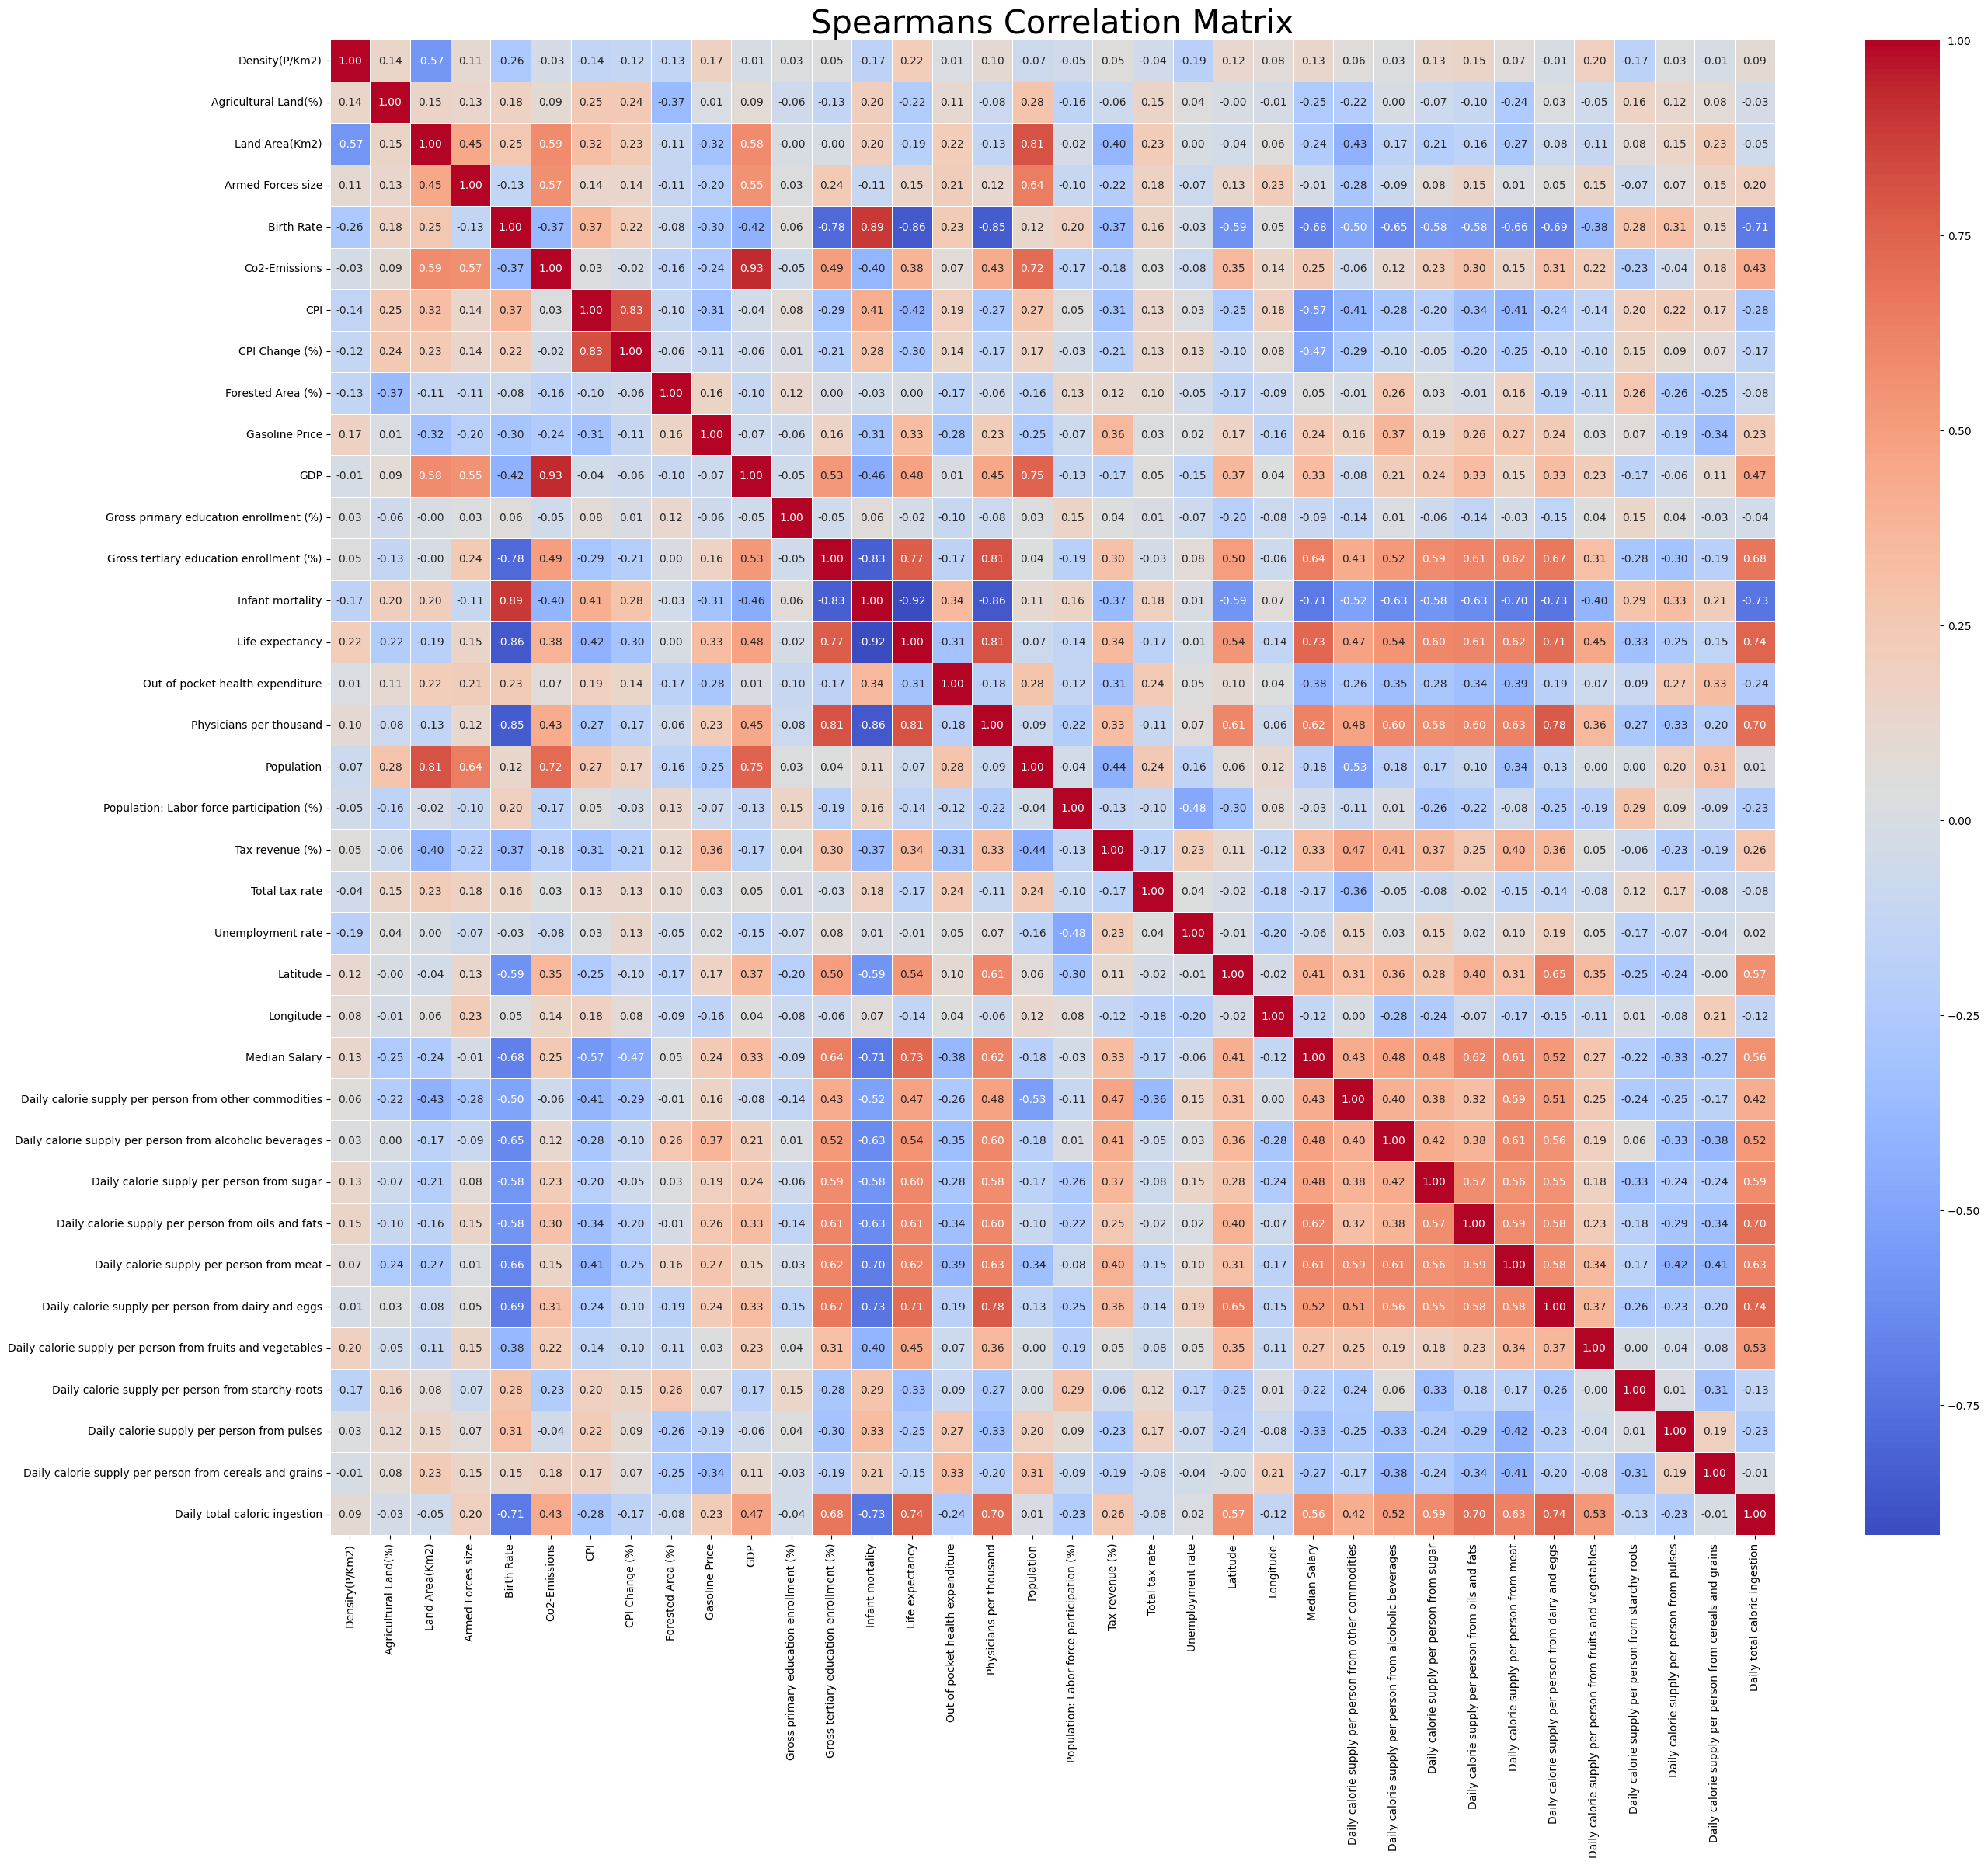

In [5]:
# Delete columns that are not needed for the correlation matrix
corr_data = cleaned_data.drop(
    [
        "Country",
        "Abbreviation",
        "Code",
        "Year",
        "Fertility Rate",
        "Urban population",
        "Maternal mortality ratio",
    ]
)

# Convert the Polars DataFrame to a Pandas DataFrame
corr_data = corr_data.to_pandas()

# Calculate the correlation matrix using the Spearman correlation coefficient
correlation_matrix = corr_data.corr(method="spearman")
plt.figure(figsize=(30, 25))
sns.heatmap(
    data=correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title(label="Spearmans Correlation Matrix", fontdict={"fontsize": 30})
plt.show()

Let's focus on the highest correlated variables with life expectancy to identify the most influential factors. We will show a plot with the top 5 most positively and negatively correlated variables with life expectancy.

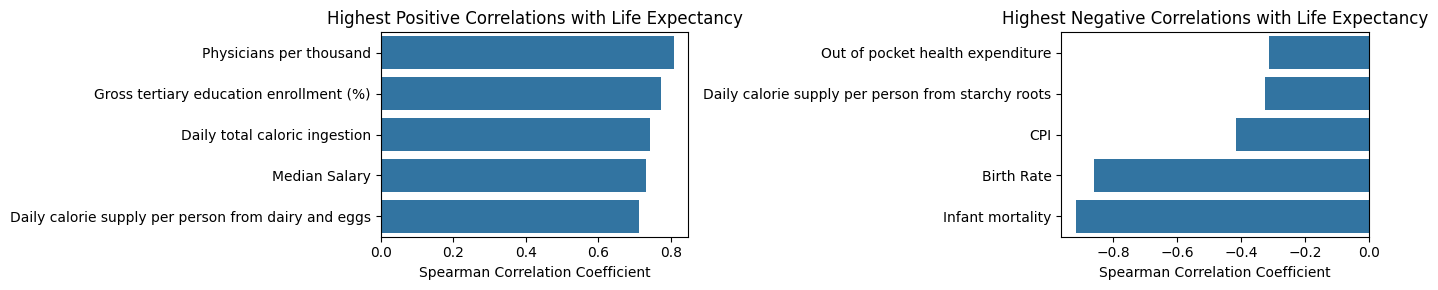

In [6]:
# Get the correlations with the target variable
correlations = (
    correlation_matrix["Life expectancy"]
    .drop("Life expectancy")
    .sort_values(ascending=False)
)

# Get the top 5 positive and negative correlations
top_positive = correlations.head(5)
top_negative = correlations.tail(5)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Positive correlations plot
sns.barplot(x=top_positive.values, y=top_positive.index, ax=axes[0])
axes[0].set_title("Highest Positive Correlations with Life Expectancy")
axes[0].set_xlabel("Spearman Correlation Coefficient")
axes[0].set_ylabel("")

# Negative correlations plot
sns.barplot(x=top_negative.values, y=top_negative.index, ax=axes[1])
axes[1].set_title("Highest Negative Correlations with Life Expectancy")
axes[1].set_xlabel("Spearman Correlation Coefficient")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

As we can see, having more physicians per thousand people suggests better healthcare availability, which is linked to longer life expectancy. Higher enrollment in tertiary education may lead to better overall health outcomes, as education is often associated with healthier lifestyle choices and access to healthcare, althought this is also highly correlated with the economic level of a country so no definite conclussion can be taken from hte education. A higher median salary typically reflects better access to resources, leading to improved nutrition and living conditions, which can increase life expectancy. Similarly, higher daily calorie supply from dairy, eggs, and meat points to better nutrition, which is also associated with improved life expectancy.

On the negative side, a higher birth rate often indicates greater strain on healthcare systems and resources, and it's often associated with lower income countries, leading to poorer health outcomes and shorter life expectancy. Similarly, higher infant mortality reflects inadequate healthcare and living conditions, contributing to lower life expectancy. While the correlation with the Consumer Price Index (CPI) is negative, it is not very strong, meaning that rising living costs may have a moderate impact on life expectancy, particularly by making healthcare and basic needs less affordable. The are no more remarkable negative correlations with life expectancy.

While the correlation matrix provides useful insights into the relationships between life expectancy and various factors, it's important to interpret these results carefully, as correlation does not imply causation. To gain a deeper understanding of the factors influencing life expectancy, we will perform an association rule analysis as our next step.

### Visualization

Before taking any further guesses on the impact of the different variables on life expectancy, we will plot the values of this variables across the world and make use of the external knowledge or biases we have to establish our hypostheses.

In [7]:
fig = px.choropleth(
    cleaned_data.to_pandas(),
    locations="Country",
    locationmode="country names",
    color="Life expectancy",
    hover_name="Country",
    color_continuous_scale="Viridis",
    projection="natural earth",
    title="Life expectancy per country",
)
fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 0})
fig.show()

c:\Users\alvar\Desktop\Local\Código\countries-dataset\.venv\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Association Rules

Association rules are a powerful technique for discovering relationships between variables in large datasets. They are widely used in market basket analysis, where the goal is to identify patterns in consumer behavior. In this study, we will apply association rules to identify patterns between different variables and life expectancy. This method will allow us to discover meaningful patterns, such as whether healthcare expenditures are strongly associated with increased life expectancy or if specific economic conditions correlate with lower life expectancy.

To achieve this, we should select columns that are most likely to have a meaningful relationship with life expectancy, either directly or through indirect factors. Let's consider the following variables:

1. **Life expectancy**: The target variable that we aim to analyze and understand in relation to other factors. It represents the average number of years a person is expected to live.

2. **Out of pocket health expenditure**: Higher out-of-pocket health expenditure can indicate a lack of access to affordable healthcare, which may negatively affect life expectancy, as individuals may delay or forgo necessary medical treatment.

3. **Physicians per thousand**: The more physicians available per thousand people, the better the healthcare access, which is expected to positively influence life expectancy by improving early diagnosis, treatment, and overall healthcare quality.

4. **Daily total caloric ingestion**: Sufficient caloric intake is essential for health, but excessive or poor-quality caloric consumption (such as from unhealthy sources) can lead to chronic diseases like obesity, which could lower life expectancy. Balanced and adequate caloric intake is typically associated with better health outcomes.

5. **GDP per capita**: A higher GDP per capita generally correlates with more resources for healthcare, education, and infrastructure, all of which contribute to better living conditions and longer life expectancy by improving overall health and access to essential services. Note that we don't have the GDP per capita in the dataset, but we can calculate it by dividing the GDP by the population.

6. **Unemployment rate**: High unemployment rates are often associated with increased stress, poverty, and reduced access to healthcare, which could negatively affect life expectancy as these factors can lead to poor mental and physical health outcomes.

7. **Urban population percentage**: Urban areas typically have better healthcare infrastructure, sanitation, and access to medical services, all of which are expected to positively influence life expectancy, as residents tend to have better health outcomes than those in rural areas with fewer resources. Note that we don't have the urban population percentage in the dataset, but we can calculate it by dividing the urban population by the total population.

8. **CO2 emissions per capita**: High levels of CO2 emissions often indicate higher levels of air pollution, which can have negative health effects, such as respiratory and cardiovascular diseases, thereby potentially lowering life expectancy in polluted areas. Note that we don't have the CO2 emissions per capita in the dataset, but we can calculate it by dividing the CO2 emissions by the population.

We made these assumtion based on the data and visualization seen so far, as well as "facts" we are taught across our own life experiences. But are these assumptions be correct? Let's find out!

Currently, we don't have a GDP per capita column in our dataset, but we can calculate it by dividing the GDP by the population.

In [8]:
# Calculate GDP per capita
cleaned_data = cleaned_data.with_columns(
    (pl.col("GDP") / pl.col("Population")).alias("GDP per capita")
)

# Drop GDP column
cleaned_data = cleaned_data.drop(["GDP"])

cleaned_data.head()

shape: (5, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Density(P ┆ Abbreviat ┆ Agricultu ┆ … ┆ Daily     ┆ Daily     ┆ Daily     ┆ GDP per  │
│ ---       ┆ /Km2)     ┆ ion       ┆ ral       ┆   ┆ calorie   ┆ calorie   ┆ total     ┆ capita   │
│ str       ┆ ---       ┆ ---       ┆ Land(%)   ┆   ┆ supply    ┆ supply    ┆ caloric   ┆ ---      │
│           ┆ f64       ┆ str       ┆ ---       ┆   ┆ per       ┆ per       ┆ ingestion ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆ perso…    ┆ perso…    ┆ ---       ┆          │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ f64       ┆          │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Afghanist ┆ 60.0      ┆ AF        ┆ 58.1      ┆ … ┆ 16.0      ┆ 1512.0    ┆ 2188.0    ┆ 502.1154 │
│ an        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 87       │
│ Albania   ┆ 105.0     ┆ AL        ┆ 43.1      ┆ … ┆ 47.0      ┆ 985.0     ┆ 3330.0    ┆ 5352.857 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 411      │
│ Algeria   ┆ 18.0      ┆ DZ        ┆ 17.4      ┆ … ┆ 61.000008 ┆ 1616.0001 ┆ 3470.0003 ┆ 3948.343 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 14        ┆ 279      │
│ Andorra   ┆ 164.0     ┆ AD        ┆ 40.0      ┆ … ┆ 13.0      ┆ 816.0     ┆ 3552.0    ┆ 40886.39 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1162     │
│ Angola    ┆ 26.0      ┆ AO        ┆ 47.5      ┆ … ┆ 66.999985 ┆ 704.9999  ┆ 2372.9996 ┆ 2973.591 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 27        ┆ 16       │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

Furthermore, we don't have a CO2 emissions per capita column in our dataset, but we can calculate it by dividing the CO2 emissions by the population.

In [9]:
# Change unit from kilotonnes to tonnes
cleaned_data = cleaned_data.with_columns(
    (pl.col("Co2-Emissions") * 1_000).alias("Co2-Emissions")
)

# Calculate CO2 emissions per capita
cleaned_data = cleaned_data.with_columns(
    (pl.col("Co2-Emissions") / pl.col("Population")).alias("CO2 emissions per capita")
)

# Drop CO2 emissions column
cleaned_data = cleaned_data.drop(["Co2-Emissions"])

cleaned_data.head()

shape: (5, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Density(P ┆ Abbreviat ┆ Agricultu ┆ … ┆ Daily     ┆ Daily     ┆ GDP per   ┆ CO2 emis │
│ ---       ┆ /Km2)     ┆ ion       ┆ ral       ┆   ┆ calorie   ┆ total     ┆ capita    ┆ sions    │
│ str       ┆ ---       ┆ ---       ┆ Land(%)   ┆   ┆ supply    ┆ caloric   ┆ ---       ┆ per      │
│           ┆ f64       ┆ str       ┆ ---       ┆   ┆ per       ┆ ingestion ┆ f64       ┆ capita   │
│           ┆           ┆           ┆ f64       ┆   ┆ perso…    ┆ ---       ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ f64       ┆           ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Afghanist ┆ 60.0      ┆ AF        ┆ 58.1      ┆ … ┆ 1512.0    ┆ 2188.0    ┆ 502.11548 ┆ 0.22796  │
│ an        ┆           ┆           ┆           ┆   ┆           ┆           ┆ 7         ┆          │
│ Albania   ┆ 105.0     ┆ AL        ┆ 43.1      ┆ … ┆ 985.0     ┆ 3330.0    ┆ 5352.8574 ┆ 1.589242 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 11        ┆          │
│ Algeria   ┆ 18.0      ┆ DZ        ┆ 17.4      ┆ … ┆ 1616.0001 ┆ 3470.0003 ┆ 3948.3432 ┆ 3.484213 │
│           ┆           ┆           ┆           ┆   ┆           ┆ 14        ┆ 79        ┆          │
│ Andorra   ┆ 164.0     ┆ AD        ┆ 40.0      ┆ … ┆ 816.0     ┆ 3552.0    ┆ 40886.391 ┆ 6.079697 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 162       ┆          │
│ Angola    ┆ 26.0      ┆ AO        ┆ 47.5      ┆ … ┆ 704.9999  ┆ 2372.9996 ┆ 2973.5911 ┆ 1.090108 │
│           ┆           ┆           ┆           ┆   ┆           ┆ 27        ┆ 6         ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

Let's check if CO2 emissions per capita have been calculated correctly.

In [10]:
# Show if there are negative values for CO2 emissions per capita
data_incorrect_co2 = cleaned_data.filter(pl.col("CO2 emissions per capita") < 0)
data_incorrect_co2.head()

shape: (0, 43)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Country ┆ Density(P/ ┆ Abbreviat ┆ Agricultu ┆ … ┆ Daily     ┆ Daily     ┆ GDP per   ┆ CO2       │
│ ---     ┆ Km2)       ┆ ion       ┆ ral       ┆   ┆ calorie   ┆ total     ┆ capita    ┆ emissions │
│ str     ┆ ---        ┆ ---       ┆ Land(%)   ┆   ┆ supply    ┆ caloric   ┆ ---       ┆ per       │
│         ┆ f64        ┆ str       ┆ ---       ┆   ┆ per       ┆ ingestion ┆ f64       ┆ capita    │
│         ┆            ┆           ┆ f64       ┆   ┆ perso…    ┆ ---       ┆           ┆ ---       │
│         ┆            ┆           ┆           ┆   ┆ ---       ┆ f64       ┆           ┆ f64       │
│         ┆            ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

We also don't have the urban population percentage in the dataset, but we can calculate it by dividing the urban population by the total population.

In [11]:
# Calculate urban population percentage
cleaned_data = cleaned_data.with_columns(
    (pl.col("Urban population") / pl.col("Population") * 100).alias(
        "Urban population percentage"
    )
)

# Drop Urban population and Population columns
cleaned_data = cleaned_data.drop(["Urban population", "Population"])

cleaned_data.head()

shape: (5, 42)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Density(P ┆ Abbreviat ┆ Agricultu ┆ … ┆ Daily     ┆ GDP per   ┆ CO2       ┆ Urban    │
│ ---       ┆ /Km2)     ┆ ion       ┆ ral       ┆   ┆ total     ┆ capita    ┆ emissions ┆ populati │
│ str       ┆ ---       ┆ ---       ┆ Land(%)   ┆   ┆ caloric   ┆ ---       ┆ per       ┆ on perce │
│           ┆ f64       ┆ str       ┆ ---       ┆   ┆ ingestion ┆ f64       ┆ capita    ┆ ntage    │
│           ┆           ┆           ┆ f64       ┆   ┆ ---       ┆           ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Afghanist ┆ 60.0      ┆ AF        ┆ 58.1      ┆ … ┆ 2188.0    ┆ 502.11548 ┆ 0.22796   ┆ 25.75399 │
│ an        ┆           ┆           ┆           ┆   ┆           ┆ 7         ┆           ┆ 9        │
│ Albania   ┆ 105.0     ┆ AL        ┆ 43.1      ┆ … ┆ 3330.0    ┆ 5352.8574 ┆ 1.589242  ┆ 61.22901 │
│           ┆           ┆           ┆           ┆   ┆           ┆ 11        ┆           ┆ 4        │
│ Algeria   ┆ 18.0      ┆ DZ        ┆ 17.4      ┆ … ┆ 3470.0003 ┆ 3948.3432 ┆ 3.484213  ┆ 73.18900 │
│           ┆           ┆           ┆           ┆   ┆ 14        ┆ 79        ┆           ┆ 1        │
│ Andorra   ┆ 164.0     ┆ AD        ┆ 40.0      ┆ … ┆ 3552.0    ┆ 40886.391 ┆ 6.079697  ┆ 87.98449 │
│           ┆           ┆           ┆           ┆   ┆           ┆ 162       ┆           ┆ 6        │
│ Angola    ┆ 26.0      ┆ AO        ┆ 47.5      ┆ … ┆ 2372.9996 ┆ 2973.5911 ┆ 1.090108  ┆ 66.17699 │
│           ┆           ┆           ┆           ┆   ┆ 27        ┆ 6         ┆           ┆ 9        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

Let's check if the percentages have been calculated correctly.

In [12]:
# Show if there are percentages greater than 100
data_incorrect_percentages = cleaned_data.filter(
    pl.col("Urban population percentage") > 100
)
data_incorrect_percentages.head()

shape: (3, 42)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Density(P ┆ Abbreviat ┆ Agricultu ┆ … ┆ Daily     ┆ GDP per   ┆ CO2       ┆ Urban    │
│ ---       ┆ /Km2)     ┆ ion       ┆ ral       ┆   ┆ total     ┆ capita    ┆ emissions ┆ populati │
│ str       ┆ ---       ┆ ---       ┆ Land(%)   ┆   ┆ caloric   ┆ ---       ┆ per       ┆ on perce │
│           ┆ f64       ┆ str       ┆ ---       ┆   ┆ ingestion ┆ f64       ┆ capita    ┆ ntage    │
│           ┆           ┆           ┆ f64       ┆   ┆ ---       ┆           ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Eswatini  ┆ 67.0      ┆ SZ        ┆ 38.434267 ┆ … ┆ 2473.9936 ┆ 3467.9588 ┆ 0.001555  ┆ 203.9315 │
│           ┆           ┆           ┆           ┆   ┆ 9         ┆ 05        ┆           ┆ 63       │
│ Nauru     ┆ 541.0     ┆ NR        ┆ 36.742243 ┆ … ┆ 2892.6817 ┆ 13189.210 ┆ 15439.023 ┆ 73683.84 │
│           ┆           ┆           ┆           ┆   ┆ 89        ┆ 631       ┆ 037       ┆ 1464     │
│ North     ┆ 83.0      ┆ MK        ┆ 37.941247 ┆ … ┆ 3027.0015 ┆ 5564.7131 ┆ 0.003811  ┆ 135.1975 │
│ Macedonia ┆           ┆           ┆           ┆   ┆ 29        ┆ 96        ┆           ┆ 32       │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

As we can see, there are three urban population percentage values that are greater than 100%. This was caused by an incorrect estimation of the urban population during preprocessing. We will address this issue by eliminating these rows from the dataset, because we don't have reliable data to correct these values.

In [13]:
# Remove rows with percentages greater than 100
data = cleaned_data.filter(pl.col("Urban population percentage") <= 100)

# Show number of rows
print(f"Number of rows: {data.height}")

Number of rows: 190


In [14]:
# Select columns to be analyzed
data = cleaned_data.select(
    [
        "Life expectancy",
        "Out of pocket health expenditure",
        "Physicians per thousand",
        "Daily total caloric ingestion",
        "GDP per capita",
        "Unemployment rate",
        "Urban population percentage",
        "CO2 emissions per capita",
    ]
)

data.head()

shape: (5, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Life       ┆ Out of     ┆ Physicians ┆ Daily     ┆ GDP per   ┆ Unemploym ┆ Urban pop ┆ CO2       │
│ expectancy ┆ pocket     ┆ per        ┆ total     ┆ capita    ┆ ent rate  ┆ ulation   ┆ emissions │
│ ---        ┆ health     ┆ thousand   ┆ caloric   ┆ ---       ┆ ---       ┆ percentag ┆ per       │
│ f64        ┆ expenditu… ┆ ---        ┆ ingestion ┆ f64       ┆ f64       ┆ e         ┆ capita    │
│            ┆ ---        ┆ f64        ┆ ---       ┆           ┆           ┆ ---       ┆ ---       │
│            ┆ f64        ┆            ┆ f64       ┆           ┆           ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 64.5       ┆ 78.4       ┆ 0.28       ┆ 2188.0    ┆ 502.11548 ┆ 11.12     ┆ 25.753999 ┆ 0.22796   │
│            ┆            ┆            ┆           ┆ 7         ┆           ┆           ┆           │
│ 78.5       ┆ 56.9       ┆ 1.2        ┆ 3330.0    ┆ 5352.8574 ┆ 12.33     ┆ 61.229014 ┆ 1.589242  │
│            ┆            ┆            ┆           ┆ 11        ┆           ┆           ┆           │
│ 76.7       ┆ 28.1       ┆ 1.72       ┆ 3470.0003 ┆ 3948.3432 ┆ 11.7      ┆ 73.189001 ┆ 3.484213  │
│            ┆            ┆            ┆ 14        ┆ 79        ┆           ┆           ┆           │
│ 84.04      ┆ 36.4       ┆ 3.33       ┆ 3552.0    ┆ 40886.391 ┆ 6.042134  ┆ 87.984496 ┆ 6.079697  │
│            ┆            ┆            ┆           ┆ 162       ┆           ┆           ┆           │
│ 60.8       ┆ 33.4       ┆ 0.21       ┆ 2372.9996 ┆ 2973.5911 ┆ 6.89      ┆ 66.176999 ┆ 1.090108  │
│            ┆            ┆            ┆ 27        ┆ 6         ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

Since association rule mining works better with categorical data, we need to convert continuous numerical variables into categorical ones. We are going to define three categories for each variable. In order to decide the thresholds for these categories, we will analyze each column's main statistics and distribution. As a standard practice, we will consider the 33rd and 66th percentiles as references to establish thresholds for defining the categories, but we will adjust them so that the distribution in categories represents reality in the best possible way.

Next, we will present some statistics and the histograms of the variables to help define the categories. It's important to note that some of these distributions may not follow a normal distribution, but this isn't an issue, as we are defining categories based on percentiles. This approach ensures that the samples are evenly distributed across the categories, mitigating the impact of non-normal distributions, which could bias the results.

**Life expectancy**

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 193.0    │
│ null_count ┆ 0.0      │
│ mean       ┆ 72.32342 │
│ std        ┆ 7.554395 │
│ min        ┆ 52.8     │
│ 25%        ┆ 66.9     │
│ 50%        ┆ 73.2     │
│ 75%        ┆ 77.6     │
│ max        ┆ 86.37    │
└────────────┴──────────┘
q33: 69.7
q66: 76.5


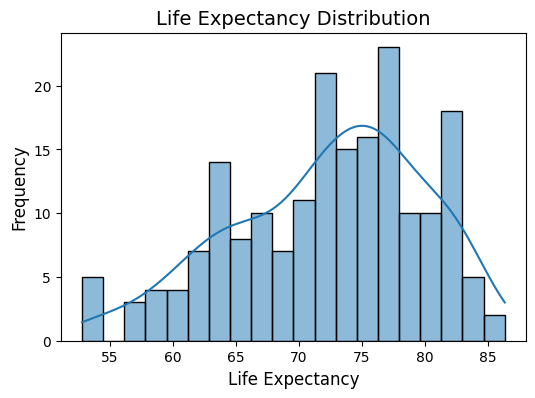

In [15]:
# Calculate statistics
life_expectancy_stats = data["Life expectancy"].describe()
print(life_expectancy_stats)

# Calculate q33 and q66
q33 = data["Life expectancy"].quantile(0.33)
q66 = data["Life expectancy"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
life_expectancy_values = data["Life expectancy"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(life_expectancy_values, bins=20, kde=True, edgecolor="black")

plt.title("Life Expectancy Distribution", fontsize=14)
plt.xlabel("Life Expectancy", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

According to the results obtained, we will define the following categories for life expectancy:

- Low: less than 70 years
- Medium: between 70 and 77 years
- High: more than 77 years


**Out of pocket health expenditure**

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 193.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 32.733509 │
│ std        ┆ 18.984664 │
│ min        ┆ 0.2       │
│ 25%        ┆ 17.6      │
│ 50%        ┆ 31.8      │
│ 75%        ┆ 43.9      │
│ max        ┆ 81.6      │
└────────────┴───────────┘
q33: 21.4
q66: 38.4


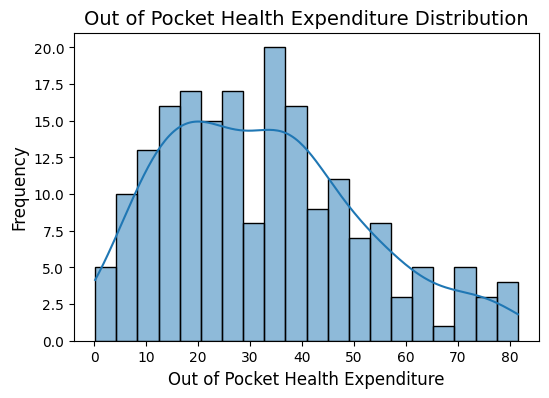

In [16]:
# Calculate statistics
out_of_pocket_health_expenditure_stats = data[
    "Out of pocket health expenditure"
].describe()
print(out_of_pocket_health_expenditure_stats)

# Calculate q33 and q66
q33 = data["Out of pocket health expenditure"].quantile(0.33)
q66 = data["Out of pocket health expenditure"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
out_of_pocket_health_expenditure_values = data[
    "Out of pocket health expenditure"
].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(
    out_of_pocket_health_expenditure_values, bins=20, kde=True, edgecolor="black"
)

plt.title("Out of Pocket Health Expenditure Distribution", fontsize=14)
plt.xlabel("Out of Pocket Health Expenditure", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

The 66th percentile of out-of-pocket health expenditure is 38.8%, but we will not consider this value as the threshold for the highest category, as it would mean that paying less than the half of the health expenditure out of pocket is considered high. Instead, we will consider a value of 50% as the threshold for the highest category. Therefore, we will define the following categories for out-of-pocket health expenditure:

- Low: less than 22%
- Medium: between 22% and 50%
- High: more than 50%

**Physicians per thousand**

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 193.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 1.828234  │
│ std        ┆ 1.671237  │
│ min        ┆ -0.221669 │
│ 25%        ┆ 0.34      │
│ 50%        ┆ 1.41      │
│ 75%        ┆ 2.89      │
│ max        ┆ 8.42      │
└────────────┴───────────┘
q33: 0.66
q66: 2.41


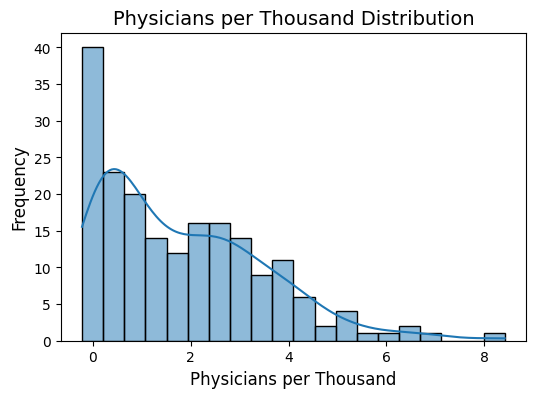

In [17]:
# Calculate statistics
physicians_per_thousand_stats = data["Physicians per thousand"].describe()
print(physicians_per_thousand_stats)

# Calculate q33 and q66
q33 = data["Physicians per thousand"].quantile(0.33)
q66 = data["Physicians per thousand"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
physicians_per_thousand_values = data["Physicians per thousand"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(physicians_per_thousand_values, bins=20, kde=True, edgecolor="black")

plt.title("Physicians per Thousand Distribution", fontsize=14)
plt.xlabel("Physicians per Thousand", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

According to the results obtained, we will define the following categories for physicians per thousand:

- Few: less than 0.75 physicians
- Moderate: between 0.75 and 2.5 physicians
- Many: more than 2.5 physicians

**Daily total caloric ingestion**

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 193.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ 2856.775285 │
│ std        ┆ 460.835812  │
│ min        ┆ 1767.995089 │
│ 25%        ┆ 2506.818546 │
│ 50%        ┆ 2880.000248 │
│ 75%        ┆ 3226.0      │
│ max        ┆ 3874.0      │
└────────────┴─────────────┘
q33: 2632.999292
q66: 3064.0009279999995


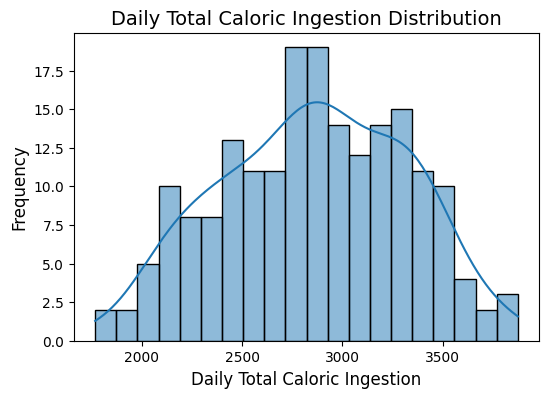

In [18]:
# Calculate statistics
daily_total_caloric_ingestion_stats = data["Daily total caloric ingestion"].describe()
print(daily_total_caloric_ingestion_stats)

# Calculate q33 and q66
q33 = data["Daily total caloric ingestion"].quantile(0.33)
q66 = data["Daily total caloric ingestion"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
daily_total_caloric_ingestion_values = data["Daily total caloric ingestion"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(daily_total_caloric_ingestion_values, bins=20, kde=True, edgecolor="black")

plt.title("Daily Total Caloric Ingestion Distribution", fontsize=14)
plt.xlabel("Daily Total Caloric Ingestion", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

We have been doing some research on the Internet, and we found that the most recommended daily caloric intake is 2000 calories for an average woman and 2500 calories for an average man, like it is stated in [[1]](https://www.nhs.uk/live-well/healthy-weight/managing-your-weight/understanding-calories/#:~:text=an%20average%20man%20needs%202%2C500,needs%202%2C000kcal%20a%20day). The 33th percentile we have obtained is 2738 calories, which is considerably higher than the recommended intake, so we will consider a lower value as the threshold which divides the lowest and medium categories. Therefore, we will define the following categories for daily total caloric ingestion:

- Low: less than 2500 calories
- Medium: between 2500 and 3200 calories
- High: more than 3200 calories

**Unemployment rate**

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 193.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 6.825629  │
│ std        ┆ 4.88565   │
│ min        ┆ -1.095598 │
│ 25%        ┆ 3.47      │
│ 50%        ┆ 5.59      │
│ 75%        ┆ 8.88      │
│ max        ┆ 28.18     │
└────────────┴───────────┘
q33: 4.2
q66: 6.952943649325224


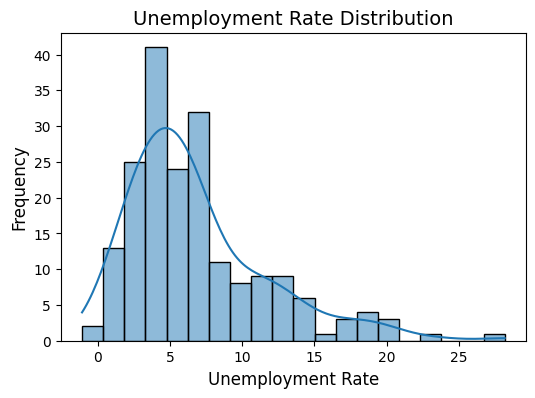

In [19]:
# Calculate statistics
unemployment_rate_stats = data["Unemployment rate"].describe()
print(unemployment_rate_stats)

# Calculate q33 and q66
q33 = data["Unemployment rate"].quantile(0.33)
q66 = data["Unemployment rate"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
unemployment_rate_values = data["Unemployment rate"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(unemployment_rate_values, bins=20, kde=True, edgecolor="black")

plt.title("Unemployment Rate Distribution", fontsize=14)
plt.xlabel("Unemployment Rate", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

There are several countries with an unemployment rate of 15% or higher, which is considered very high. The 66th percentile of the unemployment rate is around 7%, but it would be unfair to consider that a country with an unemployment rate of 7% is in the same category as some other countries that duplicate this value. Therefore, we will consider a value of 10% as the threshold for the highest category. The categories for the unemployment rate will be defined as follows:

- Low: less than 4%
- Medium: between 4% and 10%
- High: more than 10%

**GDP per capita**

shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ value         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 193.0         │
│ null_count ┆ 0.0           │
│ mean       ┆ 15690.877246  │
│ std        ┆ 25268.434004  │
│ min        ┆ 261.247473    │
│ 25%        ┆ 1912.903745   │
│ 50%        ┆ 5955.10901    │
│ 75%        ┆ 17401.721516  │
│ max        ┆ 184396.986783 │
└────────────┴───────────────┘
q33: 3216.5667385160236
q66: 11611.415449422835


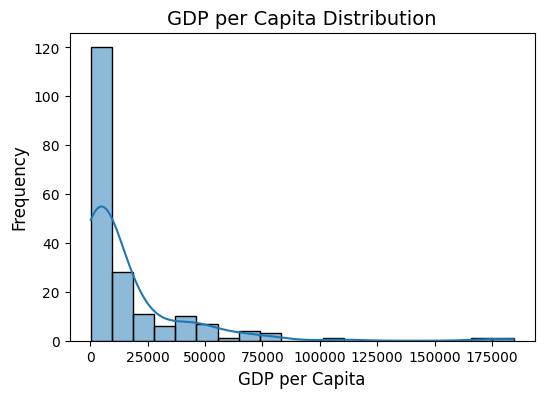

In [20]:
# Calculate statistics
gdp_per_capita_stats = data["GDP per capita"].describe()
print(gdp_per_capita_stats)

# Calculate q33 and q66
q33 = data["GDP per capita"].quantile(0.33)
q66 = data["GDP per capita"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
gdp_per_capita_values = data["GDP per capita"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(gdp_per_capita_values, bins=20, kde=True, edgecolor="black")

plt.title("GDP per Capita Distribution", fontsize=14)
plt.xlabel("GDP per Capita", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

According to the results obtained, we will define the following categories for GDP per capita:

- Low: less than 3000 USD
- Medium: between 3000 and 11000 USD
- High: more than 11000 USD

**Co2-Emissions per capita**

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 193.0        │
│ null_count ┆ 0.0          │
│ mean       ┆ 84.105348    │
│ std        ┆ 1111.040579  │
│ min        ┆ 0.001555     │
│ 25%        ┆ 0.601642     │
│ 50%        ┆ 2.392793     │
│ 75%        ┆ 5.735291     │
│ max        ┆ 15439.023037 │
└────────────┴──────────────┘
q33: 1.1019957367212028
q66: 4.467538295604025


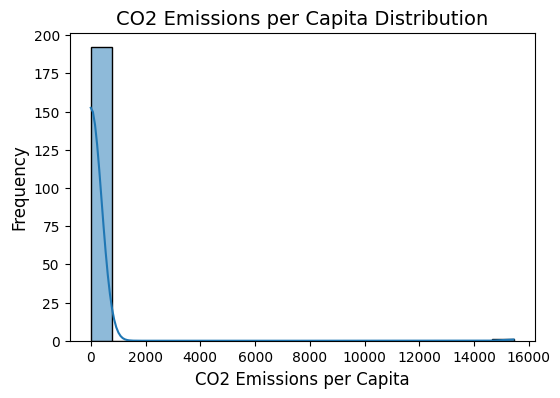

In [21]:
# Calculate statistics
co2_emissions_per_capita_stats = data["CO2 emissions per capita"].describe()
print(co2_emissions_per_capita_stats)

# Calculate q33 and q66
q33 = data["CO2 emissions per capita"].quantile(0.33)
q66 = data["CO2 emissions per capita"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
co2_emissions_per_capita_values = data["CO2 emissions per capita"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(co2_emissions_per_capita_values, bins=20, kde=True, edgecolor="black")

plt.title("CO2 Emissions per Capita Distribution", fontsize=14)
plt.xlabel("CO2 Emissions per Capita", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

In this case, we will consider the mean value as a reference to establish the thresholds. The mean is 4.2 tons per capita, so we will consider the following categories for CO2 emissions per capita:

- Low: less than 3 tons per capita
- Medium: between 3 and 6 tons per capita
- High: more than 6 tons per capita

**Urban population percentage**

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 193.0        │
│ null_count ┆ 0.0          │
│ mean       ┆ 441.396432   │
│ std        ┆ 5299.629079  │
│ min        ┆ 11.433771    │
│ 25%        ┆ 41.770005    │
│ 50%        ┆ 60.308       │
│ 75%        ┆ 79.044004    │
│ max        ┆ 73683.841464 │
└────────────┴──────────────┘
q33: 48.62599212359891
q66: 72.74600518505078


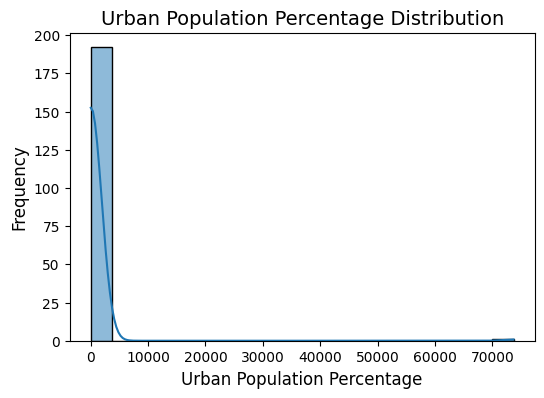

In [22]:
# Calculate statistics
urban_population_percentage_stats = data["Urban population percentage"].describe()
print(urban_population_percentage_stats)

# Calculate q33 and q66
q33 = data["Urban population percentage"].quantile(0.33)
q66 = data["Urban population percentage"].quantile(0.66)
print(f"q33: {q33}")
print(f"q66: {q66}")

# Plot histogram
urban_population_percentage_values = data["Urban population percentage"].to_numpy()

plt.figure(figsize=(6, 4))
sns.histplot(urban_population_percentage_values, bins=20, kde=True, edgecolor="black")

plt.title("Urban Population Percentage Distribution", fontsize=14)
plt.xlabel("Urban Population Percentage", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

According to the results obtained, we will define the following categories for urban population percentage:

- Low: less than 50%
- Medium: between 50% and 70%
- High: more than 70%

After establishing the categories and thresholds for each variable, we are set to perform the transformation of numerical variables into categorical ones. We will substitute the numerical columns with their corresponding categorical columns.

In [23]:
# Discretize continuous variables into categories
discretized_data = data.with_columns(
    [
        pl.when(pl.col("Life expectancy") < 70)
        .then(pl.lit("Low"))
        .when(pl.col("Life expectancy").is_between(70, 77))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("High"))
        .alias("Life_expectancy_category"),
        pl.when(pl.col("Out of pocket health expenditure") < 22)
        .then(pl.lit("Low"))
        .when(pl.col("Out of pocket health expenditure").is_between(22, 50))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("High"))
        .alias("Out_of_pocket_category"),
        pl.when(pl.col("Physicians per thousand") < 0.75)
        .then(pl.lit("Few"))
        .when(pl.col("Physicians per thousand").is_between(0.75, 2.5))
        .then(pl.lit("Moderate"))
        .otherwise(pl.lit("Many"))
        .alias("Physicians_category"),
        pl.when(pl.col("Daily total caloric ingestion") < 2500)
        .then(pl.lit("Low"))
        .when(pl.col("Daily total caloric ingestion").is_between(2500, 3200))
        .then(pl.lit("Moderate"))
        .otherwise(pl.lit("High"))
        .alias("Caloric_ingestion_category"),
        pl.when(pl.col("Unemployment rate") < 4)
        .then(pl.lit("Low"))
        .when(pl.col("Unemployment rate").is_between(4, 10))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("High"))
        .alias("Unemployment_category"),
        pl.when(pl.col("GDP per capita") < 3_000)
        .then(pl.lit("Low"))
        .when(pl.col("GDP per capita").is_between(3_000, 11_000))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("High"))
        .alias("GDP_per_capita_category"),
        pl.when(pl.col("CO2 emissions per capita") < 3)
        .then(pl.lit("Low"))
        .when(pl.col("CO2 emissions per capita").is_between(3, 6))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("High"))
        .alias("CO2_emissions_per_capita_category"),
        pl.when(pl.col("Urban population percentage") < 50)
        .then(pl.lit("Low"))
        .when(pl.col("Urban population percentage").is_between(50, 70))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("High"))
        .alias("Urban_population_percentage_category"),
    ]
)

# Drop original columns
discretized_data = discretized_data.drop(
    [
        "Life expectancy",
        "Out of pocket health expenditure",
        "Physicians per thousand",
        "Daily total caloric ingestion",
        "Unemployment rate",
        "GDP per capita",
        "CO2 emissions per capita",
        "Urban population percentage",
    ]
)

# Display transformed data
discretized_data.head()

shape: (5, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Life_expec ┆ Out_of_poc ┆ Physicians ┆ Caloric_i ┆ Unemploym ┆ GDP_per_c ┆ CO2_emiss ┆ Urban_pop │
│ tancy_cate ┆ ket_catego ┆ _category  ┆ ngestion_ ┆ ent_categ ┆ apita_cat ┆ ions_per_ ┆ ulation_p │
│ gory       ┆ ry         ┆ ---        ┆ category  ┆ ory       ┆ egory     ┆ capita_ca ┆ ercentage │
│ ---        ┆ ---        ┆ str        ┆ ---       ┆ ---       ┆ ---       ┆ teg…      ┆ _ca…      │
│ str        ┆ str        ┆            ┆ str       ┆ str       ┆ str       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆           ┆           ┆ str       ┆ str       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Low        ┆ High       ┆ Few        ┆ Low       ┆ High      ┆ Low       ┆ Low       ┆ Low       │
│ High       ┆ High       ┆ Moderate   ┆ High      ┆ High      ┆ Medium    ┆ Low       ┆ Medium    │
│ Medium     ┆ Medium     ┆ Moderate   ┆ High      ┆ High      ┆ Medium    ┆ Medium    ┆ High      │
│ High       ┆ Medium     ┆ Many       ┆ High      ┆ Medium    ┆ High      ┆ High      ┆ High      │
│ Low        ┆ Medium     ┆ Few        ┆ Low       ┆ Medium    ┆ Low       ┆ Low       ┆ Medium    │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

We can take a look at the distribution of the variables to see how the categories have been defined.

In [24]:
# Show distribution of categories
category_columns = [
    "Life_expectancy_category",
    "Out_of_pocket_category",
    "Physicians_category",
    "Caloric_ingestion_category",
    "Unemployment_category",
    "GDP_per_capita_category",
    "CO2_emissions_per_capita_category",
    "Urban_population_percentage_category",
]

distribution = {col: discretized_data[col].value_counts() for col in category_columns}

for col, dist in distribution.items():
    print(f"\nDistribution of {col}:")
    print(dist)


Distribution of Life_expectancy_category:
shape: (3, 2)
┌──────────────────────────┬───────┐
│ Life_expectancy_category ┆ count │
│ ---                      ┆ ---   │
│ str                      ┆ u32   │
╞══════════════════════════╪═══════╡
│ High                     ┆ 55    │
│ Low                      ┆ 65    │
│ Medium                   ┆ 73    │
└──────────────────────────┴───────┘

Distribution of Out_of_pocket_category:
shape: (3, 2)
┌────────────────────────┬───────┐
│ Out_of_pocket_category ┆ count │
│ ---                    ┆ ---   │
│ str                    ┆ u32   │
╞════════════════════════╪═══════╡
│ High                   ┆ 35    │
│ Medium                 ┆ 91    │
│ Low                    ┆ 67    │
└────────────────────────┴───────┘

Distribution of Physicians_category:
shape: (3, 2)
┌─────────────────────┬───────┐
│ Physicians_category ┆ count │
│ ---                 ┆ ---   │
│ str                 ┆ u32   │
╞═════════════════════╪═══════╡
│ Many                ┆ 63  

As we will use the `mlxtend` library for association rule mining, we are going to perform One-Hot Encoding to convert the categorical variables into a format suitable for the library.

In [25]:
# Select only the categorized columns
categorical_columns = [col for col in discretized_data.columns]

# Apply One-Hot Encoding
data_encoded = discretized_data.select(categorical_columns).to_dummies()

# Show the first rows of the one-hot encoded DataFrame
data_encoded.head()

shape: (5, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Life_expe ┆ Life_expe ┆ Life_expe ┆ Out_of_po ┆ … ┆ CO2_emiss ┆ Urban_pop ┆ Urban_pop ┆ Urban_po │
│ ctancy_ca ┆ ctancy_ca ┆ ctancy_ca ┆ cket_cate ┆   ┆ ions_per_ ┆ ulation_p ┆ ulation_p ┆ pulation │
│ tegory_Hi ┆ tegory_Lo ┆ tegory_Me ┆ gory_High ┆   ┆ capita_ca ┆ ercentage ┆ ercentage ┆ _percent │
│ gh        ┆ w         ┆ diu…      ┆ ---       ┆   ┆ teg…      ┆ _ca…      ┆ _ca…      ┆ age_ca…  │
│ ---       ┆ ---       ┆ ---       ┆ u8        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ u8        ┆ u8        ┆ u8        ┆           ┆   ┆ u8        ┆ u8        ┆ u8        ┆ u8       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 1         ┆ 0         ┆ 1         ┆ … ┆ 0         ┆ 0         ┆ 1         ┆ 0        │
│ 1         ┆ 0         ┆ 0         ┆ 1         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 1        │
│ 0         ┆ 0         ┆ 1         ┆ 0         ┆ … ┆ 1         ┆ 1         ┆ 0         ┆ 0        │
│ 1         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 1         ┆ 0         ┆ 0        │
│ 0         ┆ 1         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 1        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

Since the `mlxtend` library requires a Pandas DataFrame, we convert the Polars DataFrame to Pandas. We will also convert 1 and 0 values to True and False for a better computational performance, as the `mlxtend` library recommends using Boolean values.

In [26]:
# Convert to pandas DataFrame
df_encoded = data_encoded.to_pandas()

# Convert to boolean
df_encoded = df_encoded.astype(bool)

df_encoded.head()

Life_expectancy_category_High  Life_expectancy_category_Low  \
0                          False                          True   
1                           True                         False   
2                          False                         False   
3                           True                         False   
4                          False                          True   

   Life_expectancy_category_Medium  Out_of_pocket_category_High  \
0                            False                         True   
1                            False                         True   
2                             True                        False   
3                            False                        False   
4                            False                        False   

   Out_of_pocket_category_Low  Out_of_pocket_category_Medium  \
0                       False                          False   
1                       False                          False   
2                       False                           True   
3                       False                           True   
4                       False                           True   

   Physicians_category_Few  Physicians_category_Many  \
0                     True                     False   
1                    False                     False   
2                    False                     False   
3                    False                      True   
4                     True                     False   

   Physicians_category_Moderate  Caloric_ingestion_category_High  ...  \
0                         False                            False  ...   
1                          True                             True  ...   
2                          True                             True  ...   
3                         False                             True  ...   
4                         False                            False  ...   

   Unemployment_category_Medium  GDP_per_capita_category_High  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                          True                          True   
4                          True                         False   

   GDP_per_capita_category_Low  GDP_per_capita_category_Medium  \
0                         True                           False   
1                        False                            True   
2                        False                            True   
3                        False                           False   
4                         True                           False   

   CO2_emissions_per_capita_category_High  \
0                                   False   
1                                   False   
2                                   False   
3                                    True   
4                                   False   

   CO2_emissions_per_capita_category_Low  \
0                                   True   
1                                   True   
2                                  False   
3                                  False   
4                                   True   

   CO2_emissions_per_capita_category_Medium  \
0                                     False   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   Urban_population_percentage_category_High  \
0                                      False   
1                                      False   
2                                       True   
3                                       True   
4                                      False   

   Urban_population_percentage_category_Low  \
0                                      True   
1                                     False   
2    

Now, we are ready to apply the Apriori algorithm to find association rules between the selected variables and life expectancy. We will set the minimum support to 0.1, which means that an itemset must appear in at least 10% of the transactions to be considered frequent. In our case, we have 190 countries in the dataset, so an itemset must have a support of (must appear in) at least 19 countries to be considered frequent. We think this is a reasonable threshold to find meaningful associations.

In [27]:
# Apply Apriori algorithm with a minimum support of 0.1
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

We will try to find the association rules as confidently as possible. We will start with a minimum confidence threshold of 0.8, which means that the rule must be correct at least 80% of the time, but we will adjust this value based on the results obtained. Note that we are looking for rules that contain life expectancy as the consequent, since our experiment is focused on understanding the factors that influence life expectancy, so we will filter the rules accordingly.

Let's start by counting the number of rules for each life expectancy category (low, medium, high) with a minimum confidence of 0.8, which means that the rule must be correct at least 80% of the time.

In [28]:
# Generate association rules with a minimum confidence of 0.8
rules_80 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

# Sort rules by confidence
rules_80 = rules_80.sort_values(by="confidence", ascending=False)

# Show the number of rules for each category
print("=== Rule Count by Life Expectancy Category ===")
for category in [
    "Life_expectancy_category_Low",
    "Life_expectancy_category_Medium",
    "Life_expectancy_category_High",
]:
    count = rules_80[rules_80["consequents"].apply(lambda x: category in x)].shape[0]
    print(f"{category.split('_')[-1].capitalize()}: {count} rules")

=== Rule Count by Life Expectancy Category ===
Low: 78 rules
Medium: 0 rules
High: 20 rules


We obtained 84 rules for the low life expectancy category and 26 rules for the high life expectancy category, but just 1 rule for the medium life expectancy category. This means that we can not currently provide a comprehensive analysis for the medium life expectancy category, so we will see what occurs when we decrease the minimum confidence threshold to 0.7.

In [29]:
# Generate association rules with a minimum confidence of 0.7
rules_70 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort rules by confidence
rules_70 = rules_70.sort_values(by="confidence", ascending=False)

# Show the number of rules for each category
print("=== Rule Count by Life Expectancy Category ===")
for category in [
    "Life_expectancy_category_Low",
    "Life_expectancy_category_Medium",
    "Life_expectancy_category_High",
]:
    count = rules_70[rules_70["consequents"].apply(lambda x: category in x)].shape[0]
    print(f"{category.split('_')[-1].capitalize()}: {count} rules")

=== Rule Count by Life Expectancy Category ===
Low: 121 rules
Medium: 2 rules
High: 38 rules


With a confidence threshold of 0.7, we have obtained 5 rules for the medium life expectancy category. We think that would be enough to provide a comprehensive analysis for the medium life expectancy category. On the other hand, we have obtained 131 rules for the low life expectancy category and 52 rules for the high life expectancy category. 

Now, we should select the most relevant rules for each life expectancy category. We will consider the 3 rules with the highest lift values, as lift measures how much more likely the antecedent and consequent are to co-occur compared to what would be expected if they were statistically independent. High lift values indicate a strong association between the variables.

In [30]:
print("=== Top 3 Rules by Lift per Category ===")
for category in [
    "Life_expectancy_category_Low",
    "Life_expectancy_category_Medium",
    "Life_expectancy_category_High",
]:
    # Filter rules for the category
    filtered_rules = rules_70[rules_70["consequents"].apply(lambda x: category in x)]

    # Sort the filtered rules by lift and get the top 3
    top_3_rules = filtered_rules.sort_values(by="lift", ascending=False).head(3)

    # Print category and top 3 rules with their lift
    print(f"\n{category.split('_')[-1].capitalize()} - Top 3 by Lift:")
    for index, row in top_3_rules.iterrows():
        print(
            f"  Antecedents: {row['antecedents']} → Consequents: {row['consequents']} | Confidence: {row['confidence']:.2f} | Lift: {row['lift']:.2f}"
        )

=== Top 3 Rules by Lift per Category ===

Low - Top 3 by Lift:
  Antecedents: frozenset({'Caloric_ingestion_category_Low', 'Urban_population_percentage_category_Low', 'Physicians_category_Few', 'CO2_emissions_per_capita_category_Low'}) → Consequents: frozenset({'GDP_per_capita_category_Low', 'Life_expectancy_category_Low'}) | Confidence: 0.96 | Lift: 3.77
  Antecedents: frozenset({'Caloric_ingestion_category_Low', 'Urban_population_percentage_category_Low', 'Physicians_category_Few'}) → Consequents: frozenset({'CO2_emissions_per_capita_category_Low', 'GDP_per_capita_category_Low', 'Life_expectancy_category_Low'}) | Confidence: 0.96 | Lift: 3.77
  Antecedents: frozenset({'Caloric_ingestion_category_Low', 'Urban_population_percentage_category_Low', 'Physicians_category_Few'}) → Consequents: frozenset({'GDP_per_capita_category_Low', 'Life_expectancy_category_Low'}) | Confidence: 0.96 | Lift: 3.77

Medium - Top 3 by Lift:
  Antecedents: frozenset({'GDP_per_capita_category_Medium', 'Out_of_

The obtained **association rules** reveal clear patterns in the factors influencing **low, medium, and high life expectancy**. By analyzing the top rules in each category, we can identify key socioeconomic and healthcare factors that contribute to life expectancy outcomes.  

**Low Life Expectancy Category**  
The top rules indicate that **low physician density**, **low GDP per capita**, and **low caloric ingestion** are strongly associated with **low life expectancy**. Specifically, the rule:  

- **`{Few Physicians, Low Caloric Ingestion, Low Urbanization, Low CO2 Emissions} → {Low GDP per Capita, Low Life Expectancy}`**  
  - *Confidence: 0.96 | Lift: 3.72*  

confirms that limited access to healthcare and economic hardship contribute to reduced longevity. The presence of **low urbanization and low CO2 emissions** further supports the idea that these countries are less industrialized, with weaker infrastructure. The following two rules also emphasize these factors.

**Medium Life Expectancy Category**  
Countries in this category show **moderate improvements in GDP per capita and caloric ingestion** but still face challenges such as **out-of-pocket healthcare expenses**. The rule:  

- **`{Medium Out-of-Pocket Healthcare Spending, Medium GDP per Capita} → {Medium Life Expectancy}`**  
  - *Confidence: 0.81 | Lift: 2.10*  

suggests that while economic conditions are better than in low-life-expectancy countries, the financial burden of healthcare may limit access to medical services. Similarly, the rule:  

- **`{Medium GDP per Capita, Low CO2 Emissions, Moderate Caloric Ingestion} → {Medium Life Expectancy}`**  
  - *Confidence: 0.73 | Lift: 1.91*  

indicates that although food security is improving, these countries have not yet reached full industrialization.  

**High Life Expectancy Category**  
The strongest rules in this category highlight the role of **high GDP per capita**, **many physicians per capita**, and **low out-of-pocket healthcare costs** in promoting longevity. The rule:  

- **`{High Caloric Ingestion, Low Out-of-Pocket Healthcare Spending, High GDP per Capita} → {Many Physicians, High Life Expectancy}`**  
  - *Confidence: 0.86 | Lift: 4.21*  

supports the idea that **strong healthcare infrastructure and financial accessibility** contribute to longer lifespans. Additionally, the rule:  

- **`{High Caloric Ingestion, High GDP per Capita, High Urbanization,} → {Many Physicians, High Life Expectancy}`**  
  - *Confidence: 0.78 | Lift: 3.90*  

indicates that urbanized, economically developed nations tend to provide better healthcare access, further reinforcing high life expectancy.

In short, the association rules confirm well-established relationships between economic development, healthcare accessibility, and longevity. **Low life expectancy** is linked to **poor healthcare infrastructure, economic hardship, and undernutrition**, whereas **high life expectancy** is driven by **wealth, strong healthcare systems, and urbanization**. **Medium-life-expectancy countries** show transitional characteristics, improving in some aspects but still facing barriers to healthcare access. These findings emphasize the importance of **economic growth, healthcare investment, and nutrition** in improving global life expectancy.  

### Visualization

As a final addition, we can observe the average vales of these variables across the different life expectancy categories to visualize what we laid out in the association rules.

We are going to normalize first because the difference in values is too large. We use the z-score normalization method because it is robust to outliers and will allow us to compare the variables on the same scale more easily. With this, we mean the scaling the variables via this method will provide a better representation of the data on each group of life expectancy. On the other hand, this method of scaling is also dangerous as on the visualization, the proportions will not be preserved with respect to the original data but, again, let us see the difference in which have lower or higher values on each group. To compensate this limitation, we will use as the lower bound of the visualization the lowest value in any column after the transformation.

In [31]:
normalized_data = data.with_columns(
    (
        pl.col("Out of pocket health expenditure")
        - pl.col("Out of pocket health expenditure").mean()
    )
    / pl.col("Out of pocket health expenditure")
    .std()
    .alias("Out of pocket health expenditure"),
    (pl.col("Physicians per thousand") - pl.col("Physicians per thousand").mean())
    / pl.col("Physicians per thousand").std().alias("Physicians per thousand"),
    (
        pl.col("Daily total caloric ingestion")
        - pl.col("Daily total caloric ingestion").mean()
    )
    / pl.col("Daily total caloric ingestion")
    .std()
    .alias("Daily total caloric ingestion"),
    (pl.col("GDP per capita") - pl.col("GDP per capita").mean())
    / pl.col("GDP per capita").std().alias("GDP per capita"),
    (pl.col("CO2 emissions per capita") - pl.col("CO2 emissions per capita").mean())
    / pl.col("CO2 emissions per capita").std().alias("CO2 emissions per capita"),
    (
        pl.col("Urban population percentage")
        - pl.col("Urban population percentage").mean()
    )
    / pl.col("Urban population percentage").std().alias("Urban population percentage"),
).drop(["Life expectancy", "Unemployment rate"])

extended_dataset = pl.concat(
    [
        normalized_data,
        discretized_data.select(
            [
                "Life_expectancy_category",
            ]
        ),
    ],
    how="horizontal",
)


high_life_exp = extended_dataset.filter(
    pl.col("Life_expectancy_category") == "High"
).drop(["Life_expectancy_category"])
middle_life_exp = extended_dataset.filter(
    pl.col("Life_expectancy_category") == "Medium"
).drop(["Life_expectancy_category"])
low_life_exp = extended_dataset.filter(
    pl.col("Life_expectancy_category") == "Low"
).drop(["Life_expectancy_category"])
lowest_value = min(
    [
        min(high_life_exp.to_numpy().flatten()),
        min(middle_life_exp.to_numpy().flatten()),
        min(low_life_exp.to_numpy().flatten()),
    ]
)

In [32]:
fig = go.Figure()

for name, color, group_data in zip(
    ("High", "Mid", "Low"),
    ("green", "yellow", "red"),
    [high_life_exp, middle_life_exp, low_life_exp],
):
    mean_values = group_data.mean().to_pandas().values.flatten()

    fig.add_trace(
        go.Scatterpolar(
            r=mean_values,
            theta=group_data.columns,
            name=name,
            fill="toself",
            line_color=color,
        )
    )

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[lowest_value, 1.2])),
    showlegend=True,
)

fig.show()

### Conclusion

In conclusion, the analysis reveals that life expectancy is strongly influenced by factors such as healthcare availability, economic conditions, nutrition, and urbanization. Countries with more physicians per capita, higher median salaries, and greater access to tertiary education tend to have longer life expectancies, as these factors improve healthcare access, nutrition, and living standards. Additionally, higher caloric intake from foods like dairy, eggs, and meat is associated with better nutrition and, consequently, longer lifespans. On the negative side, higher birth rates and infant mortality are linked to strained healthcare systems and poor living conditions, which contribute to shorter life expectancy. Rising living costs, indicated by a negative correlation with the Consumer Price Index, may further limit access to essential resources, making it harder for populations to maintain good health.

The analysis also categorizes life expectancy into low, medium, and high categories, each shaped by distinct factors. In countries with low life expectancy, limited healthcare access, low GDP, and poor nutrition are primary contributors to shorter lifespans. These nations tend to have lower urbanization and infrastructure development. In contrast, medium life expectancy countries show moderate improvements in economic conditions but face challenges like out-of-pocket healthcare costs that restrict access to medical services. High life expectancy countries benefit from robust healthcare systems, high GDP, and low healthcare expenses, alongside high urbanization and better overall infrastructure. These findings underscore the importance of strong healthcare, economic development, and access to nutrition in promoting longevity, while highlighting the negative impact of inadequate resources on health outcomes.

---
## Q2: What factor set countries apart?

In order to answer the question *What factor set countries apart?*, we will investigate the key factors that differentiate countries based on various indicators. By identifying the factors that set countries apart, we can gain insights into the unique characteristics of different nations, such as economic development, healthcare quality, and environmental sustainability.

To to this we propose a clustering approach to group countries based on their characteristics and identify the factors that distinguish each cluster. Clustering is an unsupervised machine learning technique that groups similar data points together based on their features. By applying clustering to the dataset, we can identify patterns and relationships between countries, revealing the factors that set them apart.

Understanding key differences between countries and grouping them is essential for policymakers, economists, and researchers to develop targeted strategies and policies that address the specific needs and challenges of each group. By analyzing global data.

### Feature selection

Before applying clustering algorithms, we need to select the features that will be used to group the countries. This is important because the choice of features will determine the characteristics that differentiate the countries in each cluster, and selecting noisy or irrelevant features can lead to suboptimal clustering results.

Doing this feature selection implies:
- Removing highly correlated variables that are also highly similar in meaning, as they may introduce multicollinearity issues and bias the clustering results.
- Normalizing data to ensure that all features are on the same scale, as clustering algorithms are sensitive to the scale of the data, even more so when dealing with high-dimensional data.

#### Removing highly correlated variables

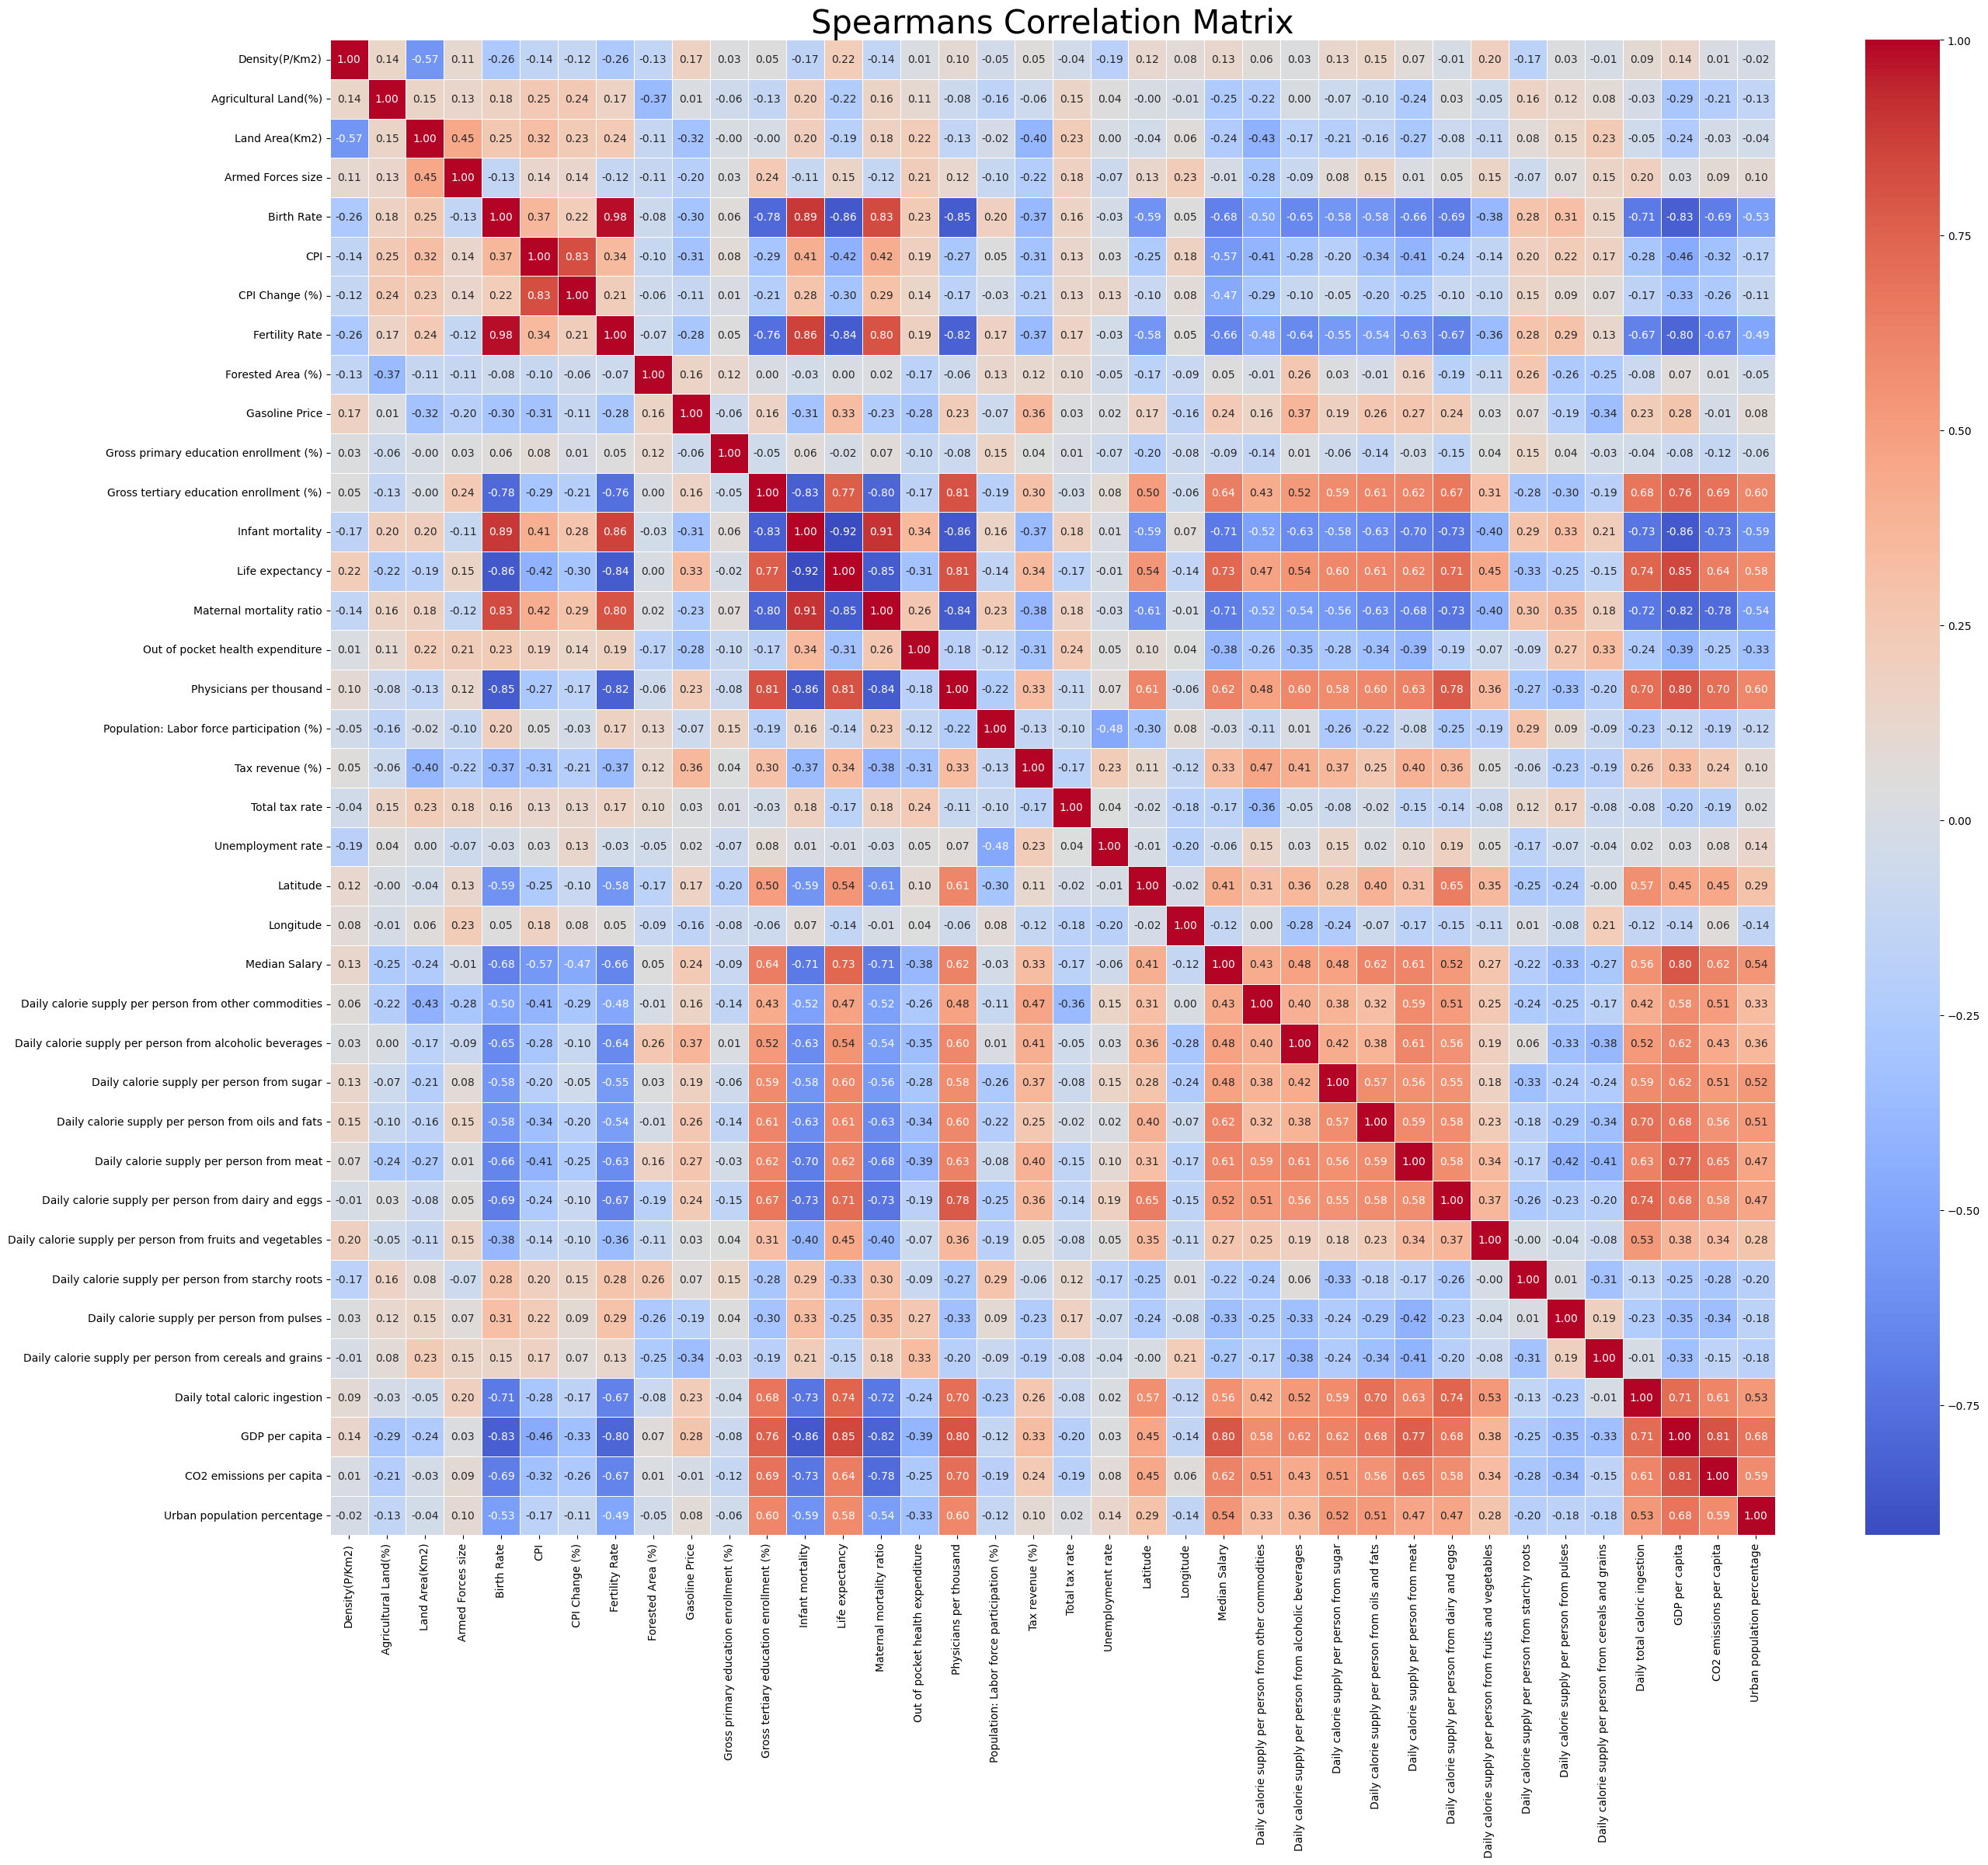

In [33]:
corr_data = cleaned_data.drop(
    [
        "Country",
        "Abbreviation",
        "Code",
        "Year",
    ]
)

corr_data = corr_data.to_pandas()

correlation_matrix = corr_data.corr(method="spearman")
plt.figure(figsize=(30, 25))
sns.heatmap(
    data=correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title(label="Spearmans Correlation Matrix", fontdict={"fontsize": 30})
plt.show()

Features to drop so far:
- Calorie ingestion. Too related to the GDP per capita as was also seen in one of the individual analyses.
- Median Salary, as it is highly correlated with the GDP per capita.
- CPI change. Too related to the CPI.
- Fertility rate, Maternal mortality ratio, and infant mortality in favour of the birth rate as they all reflect similar aspects of demographic dynamics, poor access to healthcare and living conditions.
- Longitude and Latitude, as they are not relevant for the clustering analysis.
- Gasoline price, as it does not provide any additional information to the analysis.
- Land Area, as it is not relevant for the clustering analysis.

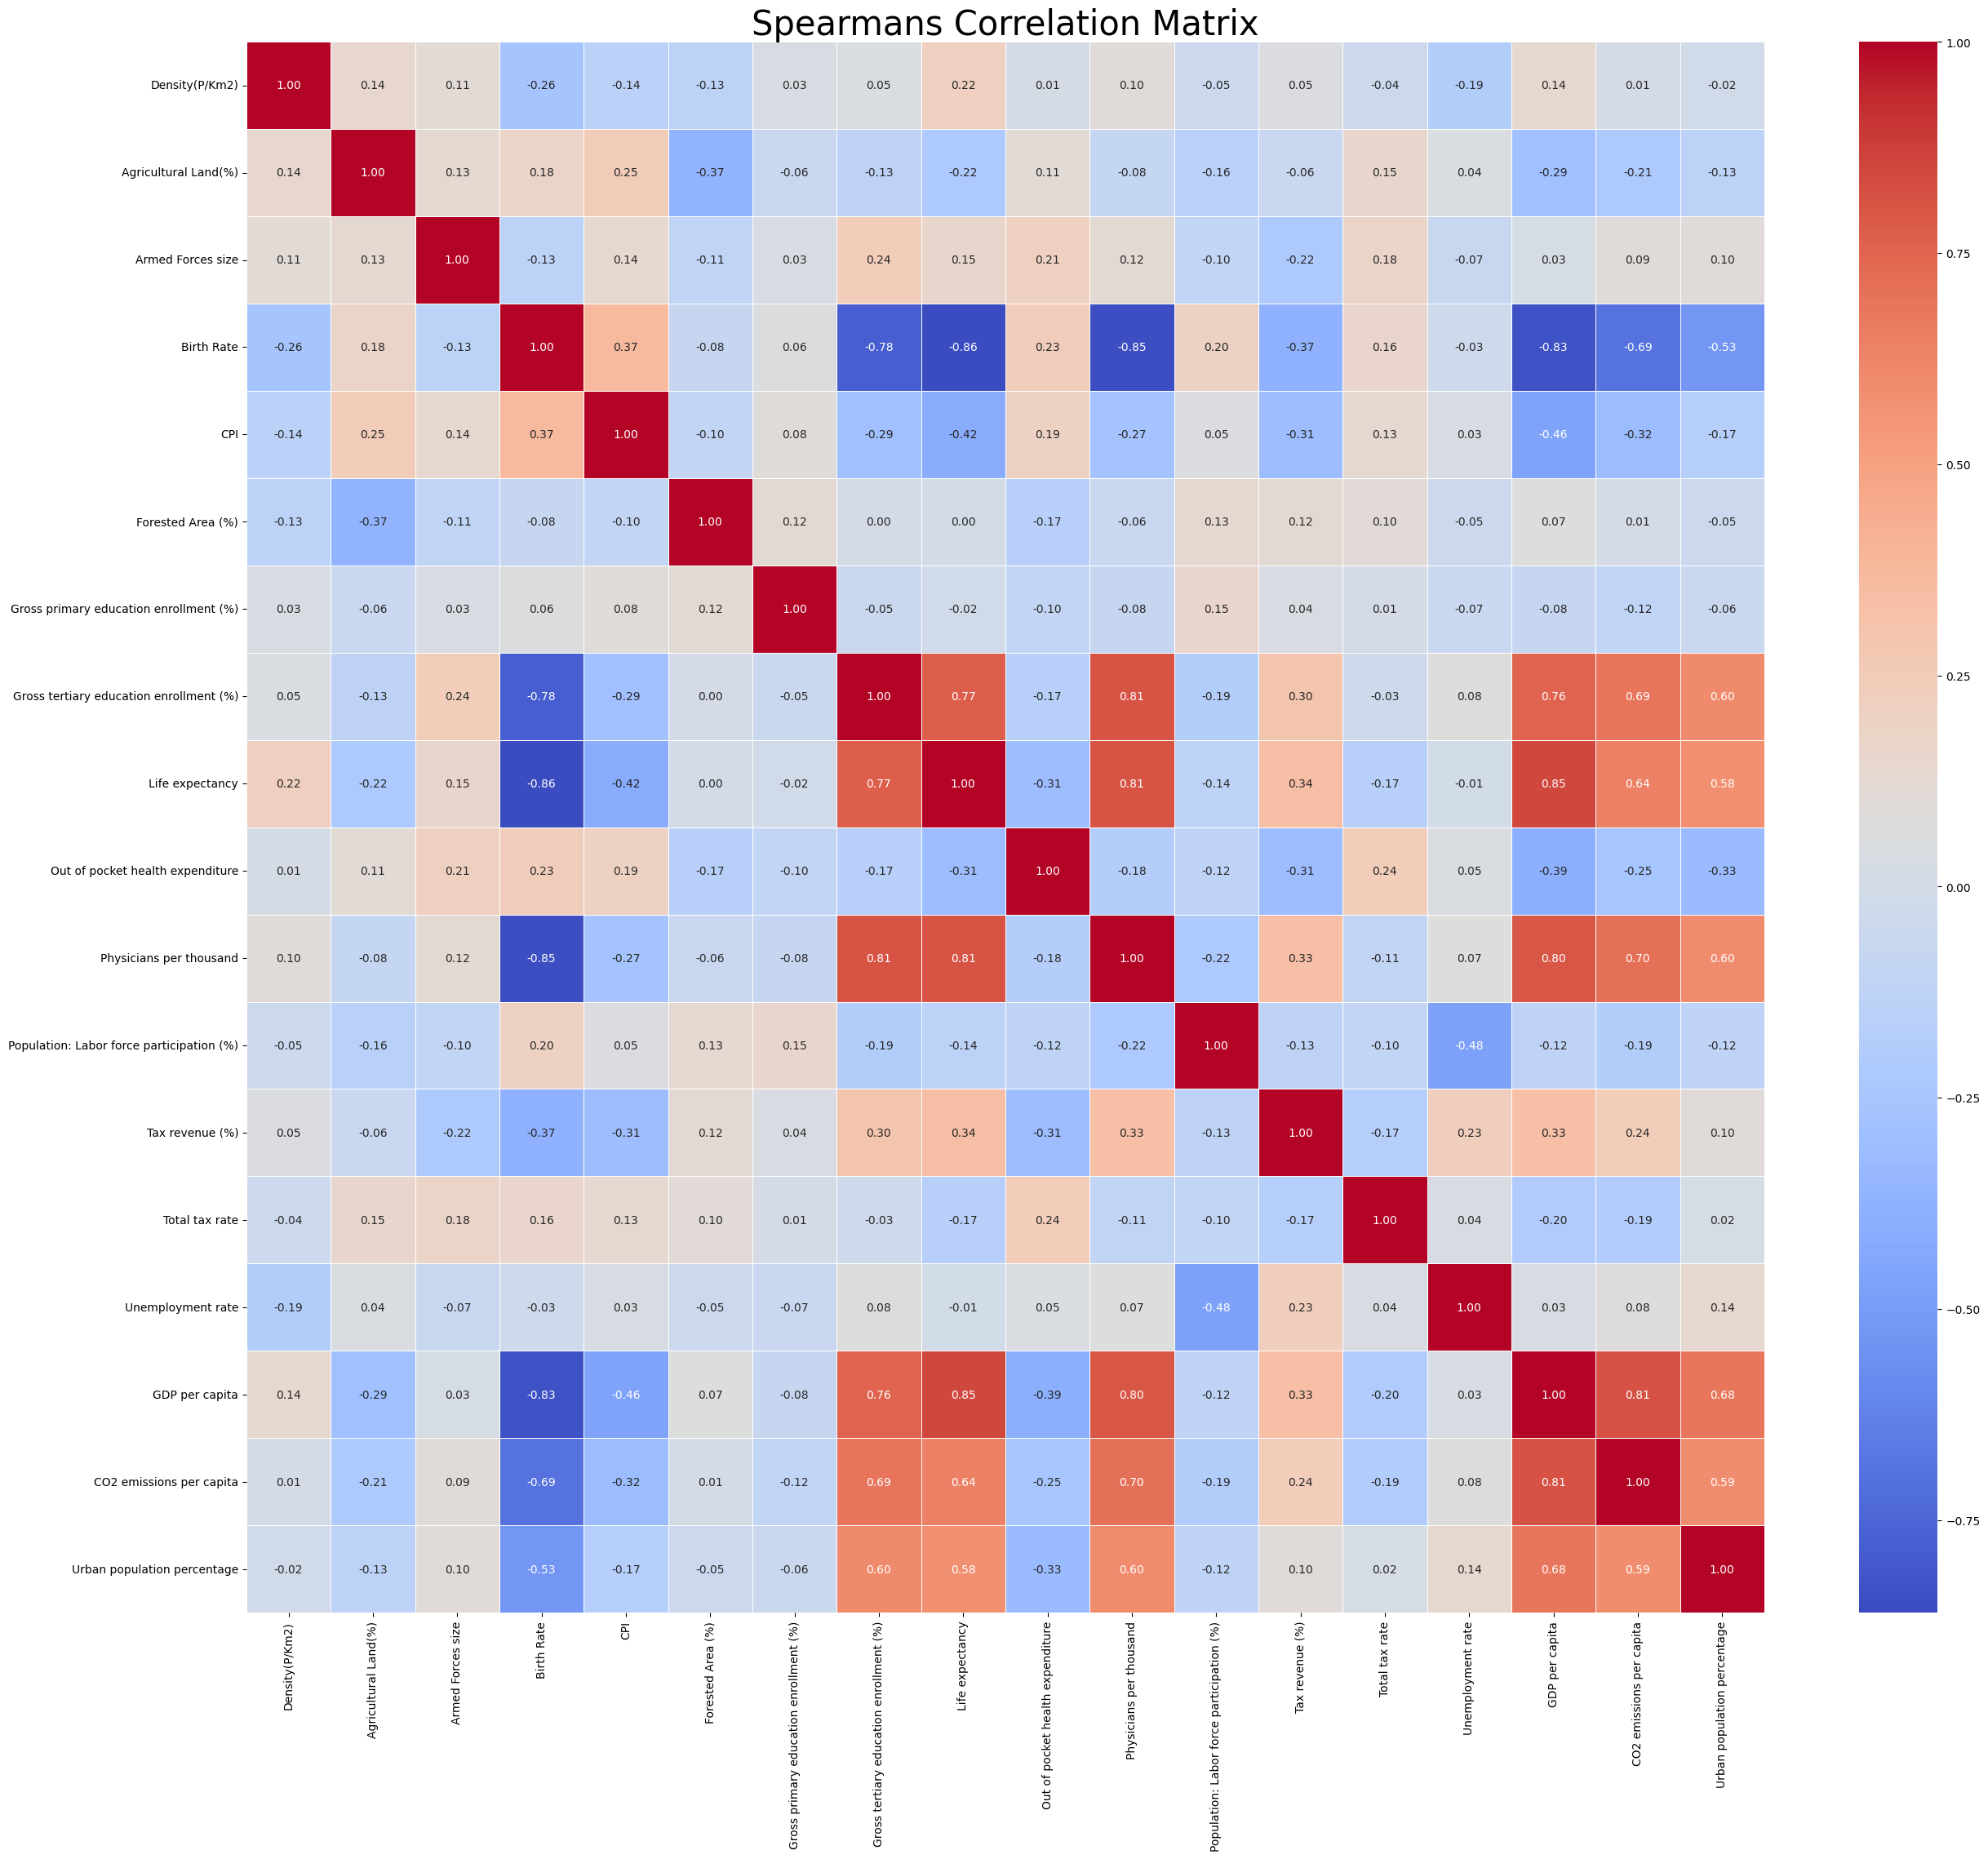

In [34]:
data = cleaned_data.drop(
    [
        "Country",
        "Abbreviation",
        "Code",
        "Year",
        "CPI Change (%)",
        "Fertility Rate",
        "Maternal mortality ratio",
        "Infant mortality",
        "Daily calorie supply per person from other commodities",
        "Daily calorie supply per person from alcoholic beverages",
        "Daily calorie supply per person from sugar",
        "Daily calorie supply per person from oils and fats",
        "Daily calorie supply per person from meat",
        "Daily calorie supply per person from fruits and vegetables",
        "Daily calorie supply per person from starchy roots",
        "Daily calorie supply per person from pulses",
        "Daily calorie supply per person from cereals and grains",
        "Daily calorie supply per person from dairy and eggs",
        "Daily total caloric ingestion",
        "Median Salary",
        "Longitude",
        "Latitude",
        "Gasoline Price",
        "Land Area(Km2)",
    ]
)

corr_data = data.to_pandas()

correlation_matrix = corr_data.corr(method="spearman")
plt.figure(figsize=(30, 25))
sns.heatmap(
    data=correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title(label="Spearmans Correlation Matrix", fontdict={"fontsize": 30})
plt.show()

Even if some features are still highly correlated, we will keep them for now as their semantical meaning is different and they could provide different insights.

#### Normalizing data

We will use the z-score normalization method to ensure that all features are on the same scale. This method is robust to outliers and will allow us to compare the features more easily.

In [35]:
normalized_data = data.with_columns(
    *[
        ((pl.col(col) - pl.col(col).mean()) / pl.col(col).std()).alias(col)
        for col in data.columns
    ]
)

normalized_data.describe()

shape: (9, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Density(P ┆ Agricultu ┆ Armed     ┆ … ┆ Unemploym ┆ GDP per   ┆ CO2       ┆ Urban    │
│ ---       ┆ /Km2)     ┆ ral       ┆ Forces    ┆   ┆ ent rate  ┆ capita    ┆ emissions ┆ populati │
│ str       ┆ ---       ┆ Land(%)   ┆ size      ┆   ┆ ---       ┆ ---       ┆ per       ┆ on perce │
│           ┆ f64       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ capita    ┆ ntage    │
│           ┆           ┆ f64       ┆ f64       ┆   ┆           ┆           ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 193.0     ┆ 193.0     ┆ 193.0     ┆ … ┆ 193.0     ┆ 193.0     ┆ 193.0     ┆ 193.0    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 4.6020e-1 ┆ -2.2089e- ┆ 0.0       ┆ … ┆ -7.3631e- ┆ 1.1045e-1 ┆ 4.6020e-1 ┆ -4.6020e │
│           ┆ 7         ┆ 16        ┆           ┆   ┆ 17        ┆ 6         ┆ 8         ┆ -18      │
│ std       ┆ 1.0       ┆ 1.0       ┆ 1.0       ┆ … ┆ 1.0       ┆ 1.0       ┆ 1.0       ┆ 1.0      │
│ min       ┆ -0.172771 ┆ -1.785046 ┆ -0.406552 ┆ … ┆ -1.621325 ┆ -0.610629 ┆ -0.075698 ┆ -0.08113 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1        │
│ 25%       ┆ -0.156183 ┆ -0.781452 ┆ -0.373217 ┆ … ┆ -0.686834 ┆ -0.545264 ┆ -0.075158 ┆ -0.07540 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ 50%       ┆ -0.130043 ┆ 0.013061  ┆ -0.292656 ┆ … ┆ -0.25291  ┆ -0.385294 ┆ -0.073546 ┆ -0.07190 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ 75%       ┆ -0.066201 ┆ 0.742525  ┆ -0.062086 ┆ … ┆ 0.420491  ┆ 0.067707  ┆ -0.070538 ┆ -0.06837 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 3        │
│ max       ┆ 13.065552 ┆ 2.024896  ┆ 8.01343   ┆ … ┆ 4.370835  ┆ 6.676556  ┆ 13.820303 ┆ 13.82029 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Finding optimal number of clusters

Before applying clustering algorithms, we need to determine the optimal number of clusters to use. This is important because the number of clusters will affect the interpretability and quality of the clustering results. We will use different methods to find the optimal number of clusters, such as the elbow method, silhouette score, and gap statistics, and then select the most appropriate number based on the results.

In [36]:
def compute_gap_statistic(X, k_max, n_replicates=10):
    """
    Compute the Gap Statistic for a range of cluster numbers.

    Parameters:
    X: array-like, shape (n_samples, n_features)
        The input data.
    k_max: int
        The maximum number of clusters to evaluate.
    n_replicates: int
        The number of bootstrap samples.

    Returns:
    gap_values: list
        The calculated gap values for each k.
    """

    # Generate reference data from a uniform distribution
    def generate_reference_data(X):
        return np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=X.shape)

    gap_values = []

    # Loop over a range of k values (1 to k_max)
    for k in range(1, k_max + 1):
        # Fit KMeans to the original data
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        original_inertia = kmeans.inertia_

        # Compute the average inertia for the reference datasets
        reference_inertia = []
        for _ in range(n_replicates):
            random_data = generate_reference_data(X)
            kmeans.fit(random_data)
            reference_inertia.append(kmeans.inertia_)

        # Calculate the Gap statistic
        gap = np.log(np.mean(reference_inertia)) - np.log(original_inertia)
        gap_values.append(gap)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, k_max + 1), gap_values, marker="o")
    plt.title("Gap Statistic vs Number of Clusters")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Gap Statistic")
    plt.grid()
    plt.show()

    return gap_values

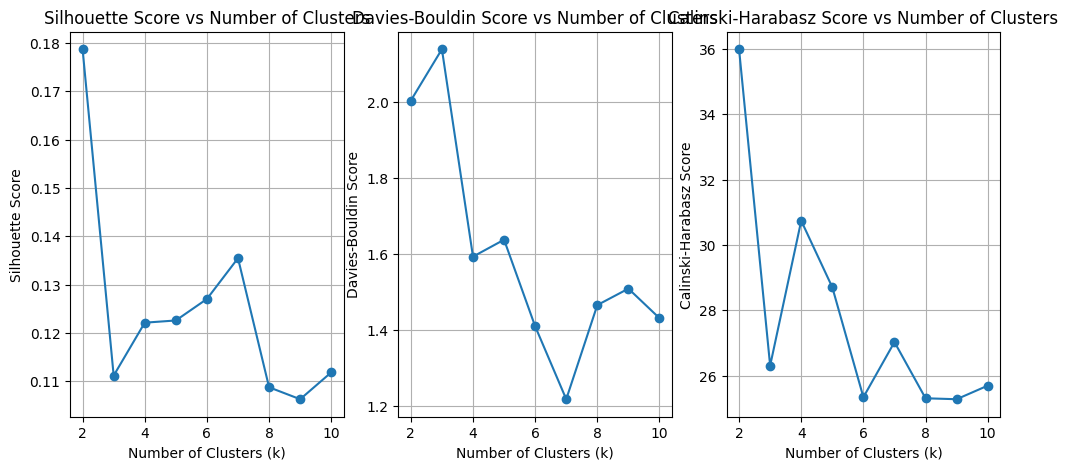

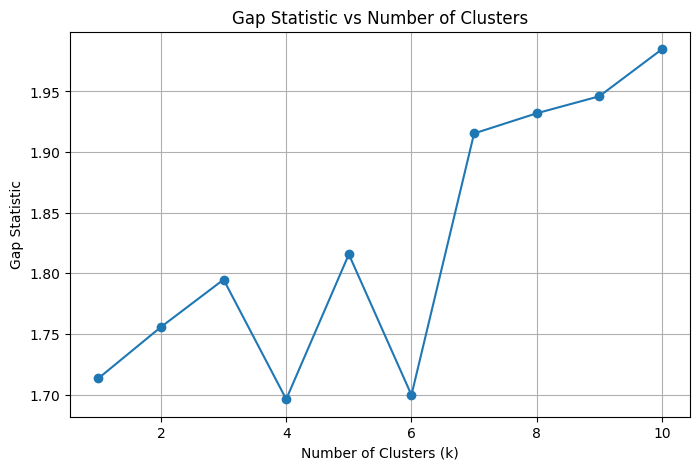

Elbow Method suggests 10 clusters.
Silhouette Method suggests 2 clusters.
Gap Statistics Method suggests 10 clusters.
Davies-Bouldin Method suggests 7 clusters.
Calinski-Harabasz Method suggests 2 clusters.


In [37]:
sse = []
k_range = range(1, 11)
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    sse.append(kmeans.inertia_)

elbow = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing").elbow

# Silhouette Method
silhouette_scores = []
db_scores = []
ch_scores = []
for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    sh_score = silhouette_score(normalized_data, kmeans.labels_)
    db_score = davies_bouldin_score(normalized_data, kmeans.labels_)
    ch_score = calinski_harabasz_score(normalized_data, kmeans.labels_)
    silhouette_scores.append(sh_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(k_range[1:], silhouette_scores, marker="o")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(k_range[1:], db_scores, marker="o")
plt.title("Davies-Bouldin Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Score")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(k_range[1:], ch_scores, marker="o")
plt.title("Calinski-Harabasz Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.grid()


optimal_silhouette = k_range[1:][np.argmax(silhouette_scores)]
optimal_db = k_range[1:][np.argmin(db_scores)]
optimal_ch = k_range[1:][np.argmax(ch_scores)]

# Gap Statistics Method
gap_values = compute_gap_statistic(normalized_data.to_numpy(), k_max=10)
optimal_gap = np.argmax(gap_values) + 1

print(f"Elbow Method suggests {elbow} clusters.")
print(f"Silhouette Method suggests {optimal_silhouette} clusters.")
print(f"Gap Statistics Method suggests {optimal_gap} clusters.")
print(f"Davies-Bouldin Method suggests {optimal_db} clusters.")
print(f"Calinski-Harabasz Method suggests {optimal_ch} clusters.")

Most supported number of clusters is 2, so we will use this number to perform the non-hierarchical clustering analysis.

### Applying clustering techniques

We will apply K-means clustering which is popular clustering algorithm that partitions the data into K clusters based on the mean distance between data points and cluster centroids.

In our case density based clustering does not make sense as we want to find similar countries based on their characteristics.

#### K-means clustering

In [38]:
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(normalized_data)

cluster_labels = kmeans.predict(normalized_data)

In [39]:
clustered_data = cleaned_data.with_columns(
    pl.Series("Cluster", cluster_labels).alias("Cluster"),
)

fig = px.choropleth(
    clustered_data.to_pandas(),
    locations="Country",
    locationmode="country names",
    color="Cluster",
    hover_name="Country",
    color_continuous_scale="Viridis",
    projection="natural earth",
    title="Cluster",
)
fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 0})
fig.show()

c:\Users\alvar\Desktop\Local\Código\countries-dataset\.venv\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



We are going to apply Mann-Whitney U test to determine if the clusters are significantly different in terms of the features. This way we can filter out the features that are not different enough between the clusters.

In [40]:
import scipy.stats as stats

cluster_0 = clustered_data.filter(pl.col("Cluster") == 0)
cluster_1 = clustered_data.filter(pl.col("Cluster") == 1)

res = {}

for col in cleaned_data.drop(["Country", "Abbreviation", "Year", "Code"]).columns:
    data_c0 = cluster_0[col].to_list()
    data_c1 = cluster_1[col].to_list()

    stat, p_value = stats.mannwhitneyu(data_c0, data_c1, alternative="two-sided")

    res[col] = {"U-statistic": stat, "p-value": p_value}

significant_columns = []
for col, values in res.items():
    if values["p-value"] < 0.05:
        print(f"{col}: U={values['U-statistic']}, p={values['p-value']} (Significant)")
        significant_columns.append(col)
    else:
        print(
            f"{col}: U={values['U-statistic']}, p={values['p-value']} (Not Significant)"
        )

Density(P/Km2): U=4084.5, p=0.17308280742723403 (Not Significant)
Agricultural Land(%): U=5914.5, p=0.0007391616623567276 (Significant)
Land Area(Km2): U=5566.0, p=0.013434953601491322 (Significant)
Armed Forces size: U=4251.5, p=0.3524462557353377 (Not Significant)
Birth Rate: U=8914.5, p=7.634400607830562e-29 (Significant)
CPI: U=6614.0, p=2.146144677425105e-07 (Significant)
CPI Change (%): U=6135.0, p=7.93723071940517e-05 (Significant)
Fertility Rate: U=8754.5, p=7.341406669201485e-27 (Significant)
Forested Area (%): U=4317.5, p=0.4479438736385237 (Not Significant)
Gasoline Price: U=3462.0, p=0.002932929677317497 (Significant)
Gross primary education enrollment (%): U=4725.0, p=0.7687885387816575 (Not Significant)
Gross tertiary education enrollment (%): U=582.0, p=1.7465071893707992e-25 (Significant)
Infant mortality: U=9000.5, p=6.0841316513143425e-30 (Significant)
Life expectancy: U=263.0, p=2.070696393262754e-29 (Significant)
Maternal mortality ratio: U=8619.5, p=3.0145271855395

In [41]:
clustered_data_pd = (
    clustered_data.drop(["Country", "Abbreviation", "Code", "Year"])
    .with_columns(
        *[
            ((pl.col(col) - pl.col(col).mean()) / pl.col(col).std()).alias(col)
            for col in clustered_data.drop(
                ["Country", "Abbreviation", "Code", "Year", "Cluster"]
            ).columns
        ]
    )
    .select([*significant_columns, "Cluster"])
    .to_pandas()
)
clustered_data_pd.describe()

Agricultural Land(%)  Land Area(Km2)    Birth Rate           CPI  \
count          1.930000e+02    1.930000e+02  1.930000e+02  1.930000e+02   
mean          -1.403598e-16   -2.761176e-17  3.221373e-16  2.669137e-16   
std            1.000000e+00    1.000000e+00  1.000000e+00  1.000000e+00   
min           -1.785046e+00   -3.599220e-01 -1.454977e+00 -6.321994e-01   
25%           -7.814517e-01   -3.465723e-01 -8.961331e-01 -4.536121e-01   
50%            1.306069e-02   -2.973371e-01 -2.072308e-01 -2.773456e-01   
75%            7.425253e-01   -8.579072e-02  8.555890e-01  6.802165e-02   
max            2.024896e+00    8.517849e+00  2.627633e+00  8.466057e+00   

       CPI Change (%)  Fertility Rate  Gasoline Price  \
count      193.000000    1.930000e+02    1.930000e+02   
mean         0.000000   -3.842637e-16   -4.193537e-16   
std          1.000000    1.000000e+00    1.000000e+00   
min         -0.476803   -1.489205e+00   -2.851514e+00   
25%         -0.253021   -7.691869e-01   -6.065333e-01   
50%         -0.185464   -3.371017e-01   -3.818367e-02   
75%         -0.058794    6.920467e-01    5.301659e-01   
max         10.467434    3.315982e+00    2.831982e+00   

       Gross tertiary education enrollment (%)  Infant mortality  \
count                             1.930000e+02      1.930000e+02   
mean                              9.203921e-18      2.300980e-17   
std                               1.000000e+00      1.000000e+00   
min                              -1.854976e+00     -1.029083e+00   
25%                              -8.752720e-01     -7.862021e-01   
50%                              -2.256968e-01     -3.469496e-01   
75%                               8.383955e-01      5.418908e-01   
max                               3.424476e+00      3.265256e+00   

       Life expectancy  ...  \
count     1.930000e+02  ...   
mean     -8.847269e-16  ...   
std       1.000000e+00  ...   
min      -2.584379e+00  ...   
25%      -7.179158e-01  ...   
50%       1.160358e-01  ...   
75%       6.984782e-01  ...   
max       1.859392e+00  ...   

       Daily calorie supply per person from dairy and eggs  \
count                                       1.930000e+02     
mean                                       -1.472627e-16     
std                                         1.000000e+00     
min                                        -1.282893e+00     
25%                                        -8.512341e-01     
50%                                        -2.066241e-01     
75%                                         7.084924e-01     
max                                         2.930099e+00     

       Daily calorie supply per person from fruits and vegetables  \
count                                       1.930000e+02            
mean                                        2.841711e-16            
std                                         1.000000e+00            
min                                        -1.660847e+00            
25%                                        -6.519765e-01            
50%                                        -1.151463e-01            
75%                                         4.309397e-01            
max                                         4.207257e+00            

       Daily calorie supply per person from starchy roots  \
count                                       1.930000e+02    
mean                                       -9.203921e-17    
std                                         1.000000e+00    
min                                        -7.843095e-01    
25%                                        -5.422384e-01    
50%                                        -3.732455e-01    
75%                                        -3.069203e-02    
max                                         5.582615e+00    

       Daily calorie supply per person from pulses  \
count                                 1.930000e+02   
mean                                 -5.982549e-17   
std                            

In [42]:
# we create a pivot table with colname, cluster and colvalue
pivot_table = clustered_data_pd.melt(
    id_vars="Cluster", var_name="Feature", value_name="Value"
)
pivot_table.head()

# remove outliers
pivot_table = pivot_table[np.abs(stats.zscore(pivot_table["Value"])) < 3]

In [43]:
for i in range(0, len(significant_columns), 5):
    fig = go.Figure()

    for col in significant_columns[i : i + 5]:
        # add two traces for each cluster
        for cluster, pos, color in zip(
            range(2), ("positive", "negative"), ("blue", "orange")
        ):
            fig.add_trace(
                go.Violin(
                    x=pivot_table[
                        (pivot_table["Cluster"] == cluster)
                        & (pivot_table["Feature"] == col)
                    ]["Feature"],
                    y=pivot_table[
                        (pivot_table["Cluster"] == cluster)
                        & (pivot_table["Feature"] == col)
                    ]["Value"],
                    legendgroup=f"Cluster {cluster}",
                    name=f"Cluster {cluster}",
                    scalegroup=f"Cluster {cluster}",
                    scalemode="count",
                    side=pos,
                    line_color=color,
                    points="outliers",
                )
            )

    fig.update_traces(meanline_visible=True)
    fig.update_layout(violingap=0, violinmode="overlay")
    fig.show()

### Understanding Results

The clustering analysis produced two well‐defined groups of countries that exhibit significant differences across several key dimensions. Below is a summary of the main findings:

- **Health and Demographics:**  
  One cluster stands out with markedly lower values in indicators such as infant mortality, birth rate, fertility rate, and maternal mortality. These patterns suggest better healthcare systems and living conditions, which in turn are associated with higher life expectancy.

- **Economic and Nutritional Factors:**  
  Countries in the superior cluster show much higher GDP per capita and greater daily caloric intake. These economic advantages likely contribute to improved nutrition and overall wellbeing. Additionally, a higher number of physicians per thousand inhabitants further reinforces the role of accessible healthcare services in this group.

- **Urbanization and Industrialization:**  
  The analysis also indicates that the cluster with better health outcomes tends to be more urbanized. These nations exhibit higher CO2 emissions per capita, which can be seen as a proxy for industrial activity and overall economic development. Although higher emissions often raise environmental concerns, in this context they align with improved infrastructure and accessible public services.

- **Educational Opportunities:**  
  An increased enrollment in tertiary education in the high-performing cluster underscores the close link between a strong economy, better healthcare, and enhanced educational prospects.

Overall, the results confirm that countries separating into one cluster typically benefit from stronger healthcare infrastructure, economic development, and modern urbanization—all contributing to higher life expectancy and better overall standards of living. The statistical tests (e.g., the Mann–Whitney U test) further confirm that these differences are significant, suggesting clear pathways for policymakers and researchers to target improvements where needed.### Understanding results

### Conclusions

Final insigths and recommendations to policymakers, healthcare professionals, and economists to improve public health strategies and resource allocation are (Based on both questions analysis):

- **Invest in Healthcare Access:**  
  The strong positive correlation between life expectancy and indicators such as the number of physicians per thousand inhabitants and lower infant mortality suggests that improving healthcare infrastructure should be a top priority. Expanding access to healthcare professionals, preventive care, and early treatment services can lead to significant improvements in overall health outcomes.

- **Support Economic and Nutritional Improvements:**  
  Higher GDP per capita and better daily caloric intake were associated with longer life expectancy. Investments that boost economic growth (even if gradual) can allow countries to allocate more resources to healthcare, education, and nutrition. Improving food security and nutritional quality is essential to support a healthier population.

- **Focus on Reducing Birth and Infant Mortality Rates:**  
  The negative associations observed with higher birth rates and infant mortality indicate that family planning services, maternal health programs, and improved neonatal care can dramatically enhance life expectancy. Implementing public health campaigns that address these issues may also contribute to slowing population pressures on underfunded healthcare systems.

- **Enhance Educational Opportunities:**  
  Although the correlation between tertiary education levels and life expectancy might be partially confounded by economic development, countries that invest in education tend to see broader social and health benefits. Promoting universal education can empower populations to make healthier life choices and improve economic prospects.

Overall, while there is no single “quick fix,” a balanced focus on strengthening healthcare infrastructure, supporting economic development, improving nutrition, reducing excessive birth rates, and expanding educational opportunities will provide a multilateral strategy to uplift overall health and life expectancy in underdeveloped countries.